In [1]:
### from typing import Union
from collections import Counter

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.torch_generic_model_training import train_model_with_cv, train_model, evaluate_model
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
from lib.datetime import get_current_timestamp
import lib.torch_device as tdev

from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split_random, split_sequential
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.ds.numpy_dataset import NumpyDataset
from lib.ds.bird_combiner import combine_birds

from lib.loss.cost_matrix_loss import CostMatrixLoss
from lib.loss.cross_entropy_cost_matrix_loss import CrossEntropyCostMatrixLoss

from lib.model.model_persistence import save_model, load_model, save_model_with_scaler

from lib.model.combined_classifier import CombinedClassifier, CombinedClassifierHyperParameters
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.model.sliding_attention_classifier import SlidingAttentionClassifier, SlidingAttentionClassifierHyperParameters
from lib.model.cnn_classifier import CNNClassifier, CNNClassifierHyperParameters
from lib.model.cnn import ConvHyperParameters, CNNHyperParameters
from lib.model.fnn import FNN, FNNHyperParameters

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [4]:
test_size_pct = 0.0
random_test_splitting = False
random_test_splitting_seed = 69420666

if random_test_splitting:
    dataset_raw_train, dataset_raw_test = split_random(NumpyDataset(data_raw, labels), test_size_pct=test_size_pct, seed=random_test_splitting_seed)
else:
    dataset_raw_train, dataset_raw_test = split_sequential(NumpyDataset(data_raw, labels), test_size_pct=test_size_pct)


print(f'{dataset_raw_train.data.shape = }')
print(f'{dataset_raw_test.data.shape  = }' if dataset_raw_test is not None else 'dataset_raw_test             = None')

print(f'{Counter(dataset_raw_train.labels.flatten().tolist()) = }')
print(f'{Counter(dataset_raw_test.labels.flatten().tolist())  = }' if dataset_raw_test is not None else '')

dataset_raw_train.data.shape = (1200, 100, 548)
dataset_raw_test             = None
Counter(dataset_raw_train.labels.flatten().tolist()) = Counter({0.0: 85358, 2.0: 8954, 3.0: 8198, 1.0: 5833, 5.0: 5111, 6.0: 4222, 4.0: 2324})



### Create sequences

In [5]:
sequences_ds_train = combine_birds(
    dataset_raw_train, 
    sequence_length=300,
    random_seed=42
)
print(f'{sequences_ds_train.data.shape   = }')
print(f'{sequences_ds_train.labels.shape = }\n\n')


sequences_ds_test = combine_birds(
    dataset_raw_test, 
    sequence_length=300,
    random_seed=42
)

if sequences_ds_test is not None:
    print(f'{sequences_ds_test.data.shape   = }')
    print(f'{sequences_ds_test.labels.shape = }')
else:
    print('sequences_ds_test = None')

Creating random sequence (num_duplicates = 1):   8%|██▍                            | 9496/120000 [00:00<00:07, 13822.42it/s]


KeyboardInterrupt: 

#### Store/Recover Sequences

In [5]:
if random_test_splitting:
    sequences_key = f'{test_size_pct} {random_test_splitting} {random_test_splitting_seed}'
else:
    sequences_key = f'{test_size_pct} {random_test_splitting}'

# key -> (train_sequences, test_sequences)
sequences_dict: dict['str', tuple[NumpyDataset, NumpyDataset]] = None

In [39]:
if sequences_dict is None:
    sequences_dict = dict()

sequences_dict[sequences_key] = (sequences_ds_train, sequences_ds_test)

%store sequences_dict

Stored 'sequences_dict' (dict)


In [6]:
%store -r sequences_dict

if sequences_dict is not None:
    if sequences_key in sequences_dict:
        sequences_ds_train, sequences_ds_test = sequences_dict[sequences_key]
    else:
        print(f'Key {sequences_key}  not found')
else:
    print('sequences_dict is None!')

print(f'{sequences_ds_train.data.shape = }')
print(f'{sequences_ds_test.data.shape if sequences_ds_test is not None else "None" = }')

sequences_ds_train.data.shape = (400, 300, 548)
sequences_ds_test.data.shape if sequences_ds_test is not None else "None" = 'None'


In [19]:
from collections import Counter

def print_label_count(labels: np.ndarray):
    counter = Counter(labels.reshape((-1)).tolist())
    
    total = sum(counter.values())
    
    for key in counter.keys():
        counter[key] /= total
    
    items = sorted(counter.items(), key=lambda item: item[0])
    
    print([f'{int(item[0])}: {item[1]:.4f}' for item in items])

print_label_count(sequences_ds_train.labels)

['0: 0.7113', '1: 0.0486', '2: 0.0746', '3: 0.0683', '4: 0.0194', '5: 0.0426', '6: 0.0352']


# Hyper Parameters

In [7]:
ac_hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    # attention_window_size=30,
    # step=6,
    
    d_model=48,
    num_heads=12,
    attention_stack_size=2,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.4,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[48, 48],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
    
    add_residual=True,
)

In [14]:
cnn_hyper_parameters = CNNClassifierHyperParameters(
    
    in_fnn_hyper_parameters=FNNHyperParameters(
        in_features=data_raw.shape[-1],
        layers_out_features=[48, 48],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
    
    cnn1d_embedding_hyper_parameters=FNNHyperParameters(
        in_features=48,
        layers_out_features=[32, 32],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
    
    cnn1d_hyper_parameters=CNNHyperParameters(
        in_channels=32,

        layers_hyper_parameters=[
            ConvHyperParameters(out_channels=32, kernel_size=5, stride=1, dilation=1, groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
        ],

        normalize_before=False,
        normalize_after=True,

        activation_provider=lambda: nn.LeakyReLU(),
        
        dropout=0.45
    ),
    
    
    cnn2d_embedding_hyper_parameters=FNNHyperParameters(
        in_features=48,
        layers_out_features=[48, 48],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
    
    cnn2d_hyper_parameters=CNNHyperParameters(
        in_channels=1,

        layers_hyper_parameters=[
            ConvHyperParameters(out_channels=32, kernel_size=(5, 5), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=32, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
            ConvHyperParameters(out_channels=1, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
        ],

        normalize_before=False,
        normalize_after=True,

        activation_provider=lambda: nn.LeakyReLU(),
        
        dropout=0.45
    ),
    
    
    out_fnn_hyper_parameters=FNNHyperParameters(
        in_features=32 + 48,
        layers_out_features=[48, NUM_CLASSES],
        dropout=0.45,
        activation_provider=lambda: nn.LeakyReLU()
    ),
)

In [102]:
combined_hyper_parameters = CombinedClassifierHyperParameters(
    
    cnn_classifier_hyper_parameters=CNNClassifierHyperParameters(
    
        cnn1d_embedding_hyper_parameters=FNNHyperParameters(
            in_features=data_raw.shape[-1],
            layers_out_features=[32, 32],
            dropout=0.45,
            activation_provider=lambda: nn.LeakyReLU()
        ),

        cnn1d_hyper_parameters=CNNHyperParameters(
            in_channels=32,

            layers_hyper_parameters=[
                ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
                ConvHyperParameters(out_channels=32, kernel_size=3, stride=1, dilation=1, groups=1, bias=False, padding='same'),
            ],

            normalize_before=False,
            normalize_after=True,

            activation_provider=lambda: nn.LeakyReLU(),

            dropout=0.45
        ),


        cnn2d_embedding_hyper_parameters=FNNHyperParameters(
            in_features=data_raw.shape[-1],
            layers_out_features=[32, 32],
            dropout=0.45,
            activation_provider=lambda: nn.LeakyReLU()
        ),

        cnn2d_hyper_parameters=CNNHyperParameters(
            in_channels=1,

            layers_hyper_parameters=[
                ConvHyperParameters(out_channels=32, kernel_size=(5, 5), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
                ConvHyperParameters(out_channels=16, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
                ConvHyperParameters(out_channels=1, kernel_size=(3, 3), stride=(1, 1), dilation=(1, 1), groups=1, bias=False, padding='same'),
            ],

            normalize_before=False,
            normalize_after=True,

            activation_provider=lambda: nn.LeakyReLU(),

            dropout=0.45
        ),


        out_fnn_hyper_parameters=FNNHyperParameters(
            in_features=32 + 32,
            layers_out_features=[48],
            dropout=0.45,
            activation_provider=lambda: nn.LeakyReLU()
        ),
    ),
    
    
    attention_classifier_hyper_parameters=AttentionClassifierHyperParameters(
        in_features=48,
        out_features=NUM_CLASSES,

        # attention_window_size=300,
        # step=6,

        d_model=48,
        num_heads=8,
        attention_stack_size=0,
        attention_stack_activation_provider=lambda: nn.LeakyReLU(),
        attention_dropout=0.4,

        in_linear_hidden_out_features=[48],
        out_linear_hidden_out_features=[24, 16],
        linear_activation_provider=lambda: nn.LeakyReLU(),
        linear_dropout=0.4,

        add_residual=True,
    ),
)

TypeError: __init__() missing 1 required positional argument: 'in_fnn_hyper_parameters'

#### Training HP

In [11]:
training_gain_matrix = np.array([
    [ 0.05, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2],
    [-0.25,  1.0, -0.3, -0.1, -0.1, -0.1, -0.1],
    [-0.02, -0.1,  1.0, -0.1, -0.1, -0.1, -0.1],
    [-0.25, -0.1, -0.3,  1.0, -0.1, -0.1, -0.1],
    [-0.25, -0.1, -0.3, -0.1,  1.0, -0.1, -0.1],
    [-0.25, -0.1, -0.3, -0.1, -0.1,   1., -0.1],
    [-0.25, -0.1, -0.3, -0.1, -0.1, -0.1,  1.0],
])

# training_gain_matrix += np.array([
#     [  0.25,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
#     [ -0.10,  1.00,  0.00, -1.00,  0.00,  0.00,  0.00],
#     [ -0.10,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
#     [ -0.10,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
#     [ -0.50,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
#     [ -0.55,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
#     [ -0.35,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
# ])

training_gain_matrix += np.array([
    [  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
    [ -0.20,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
    [ -0.20,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
    [ -0.20,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
    [ -0.20,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
    [ -0.70,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
    [ -0.20,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
])

In [12]:
training_hyper_parameters = TrainingHyperParameters(
    batch_size=128,

    loss_module_provider=lambda balancing_loss_weights: CrossEntropyCostMatrixLoss(
        cross_entropy_loss=nn.CrossEntropyLoss(weight=balancing_loss_weights * torch.tensor([
            0.3, # 0
            1.0, # 1
            1.0, # 2
            1.0, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]).to(device)),
        cross_entropy_weight=1e-3,
        
        cost_matrix_loss=CostMatrixLoss(torch.Tensor(training_gain_matrix), is_gain_matrix=True),
        cost_matrix_weight=1.0,
    ),

    optimizer_provider=lambda model, lr: optim.Adamax(
        model.parameters(),
        lr=lr,
        betas=(0.9, 0.98),
        eps=1e-9,
        weight_decay=1e-4,
    ),

    num_epochs=80,
    lr=1e-2,

    lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
    lr_scheduler_gamma=0.75,
    lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
    # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
    #     optimizer, 
    #     milestones=milestones,
    #     gamma=gamma
    # )
)

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                       | 0/8 [00:00<?, ?it/s]




Executing CV for fold 0
Training fold 0


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74360,  5171,  7883,  7200,  2002,  4748,  3636]
eval label counts  = [10998,   662,  1071,   998,   322,   363,   586]

balancing loss weights                    = [ 1.00, 14.38,  9.43, 10.33, 37.14, 15.66, 20.45]
balancing eval loss weights (theoretical) = [ 1.00, 16.61, 10.27, 11.02, 34.16, 30.30, 18.77]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000013, num_samples = 105000, num_correct = 23710, acc = 0.225810, bacc = 0.159733, score = -0.281059
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000127, num_samples = 15000, num_correct =  7426, acc = 0.495067, bacc = 0.247559, score = -0.087590
Training Epoch 

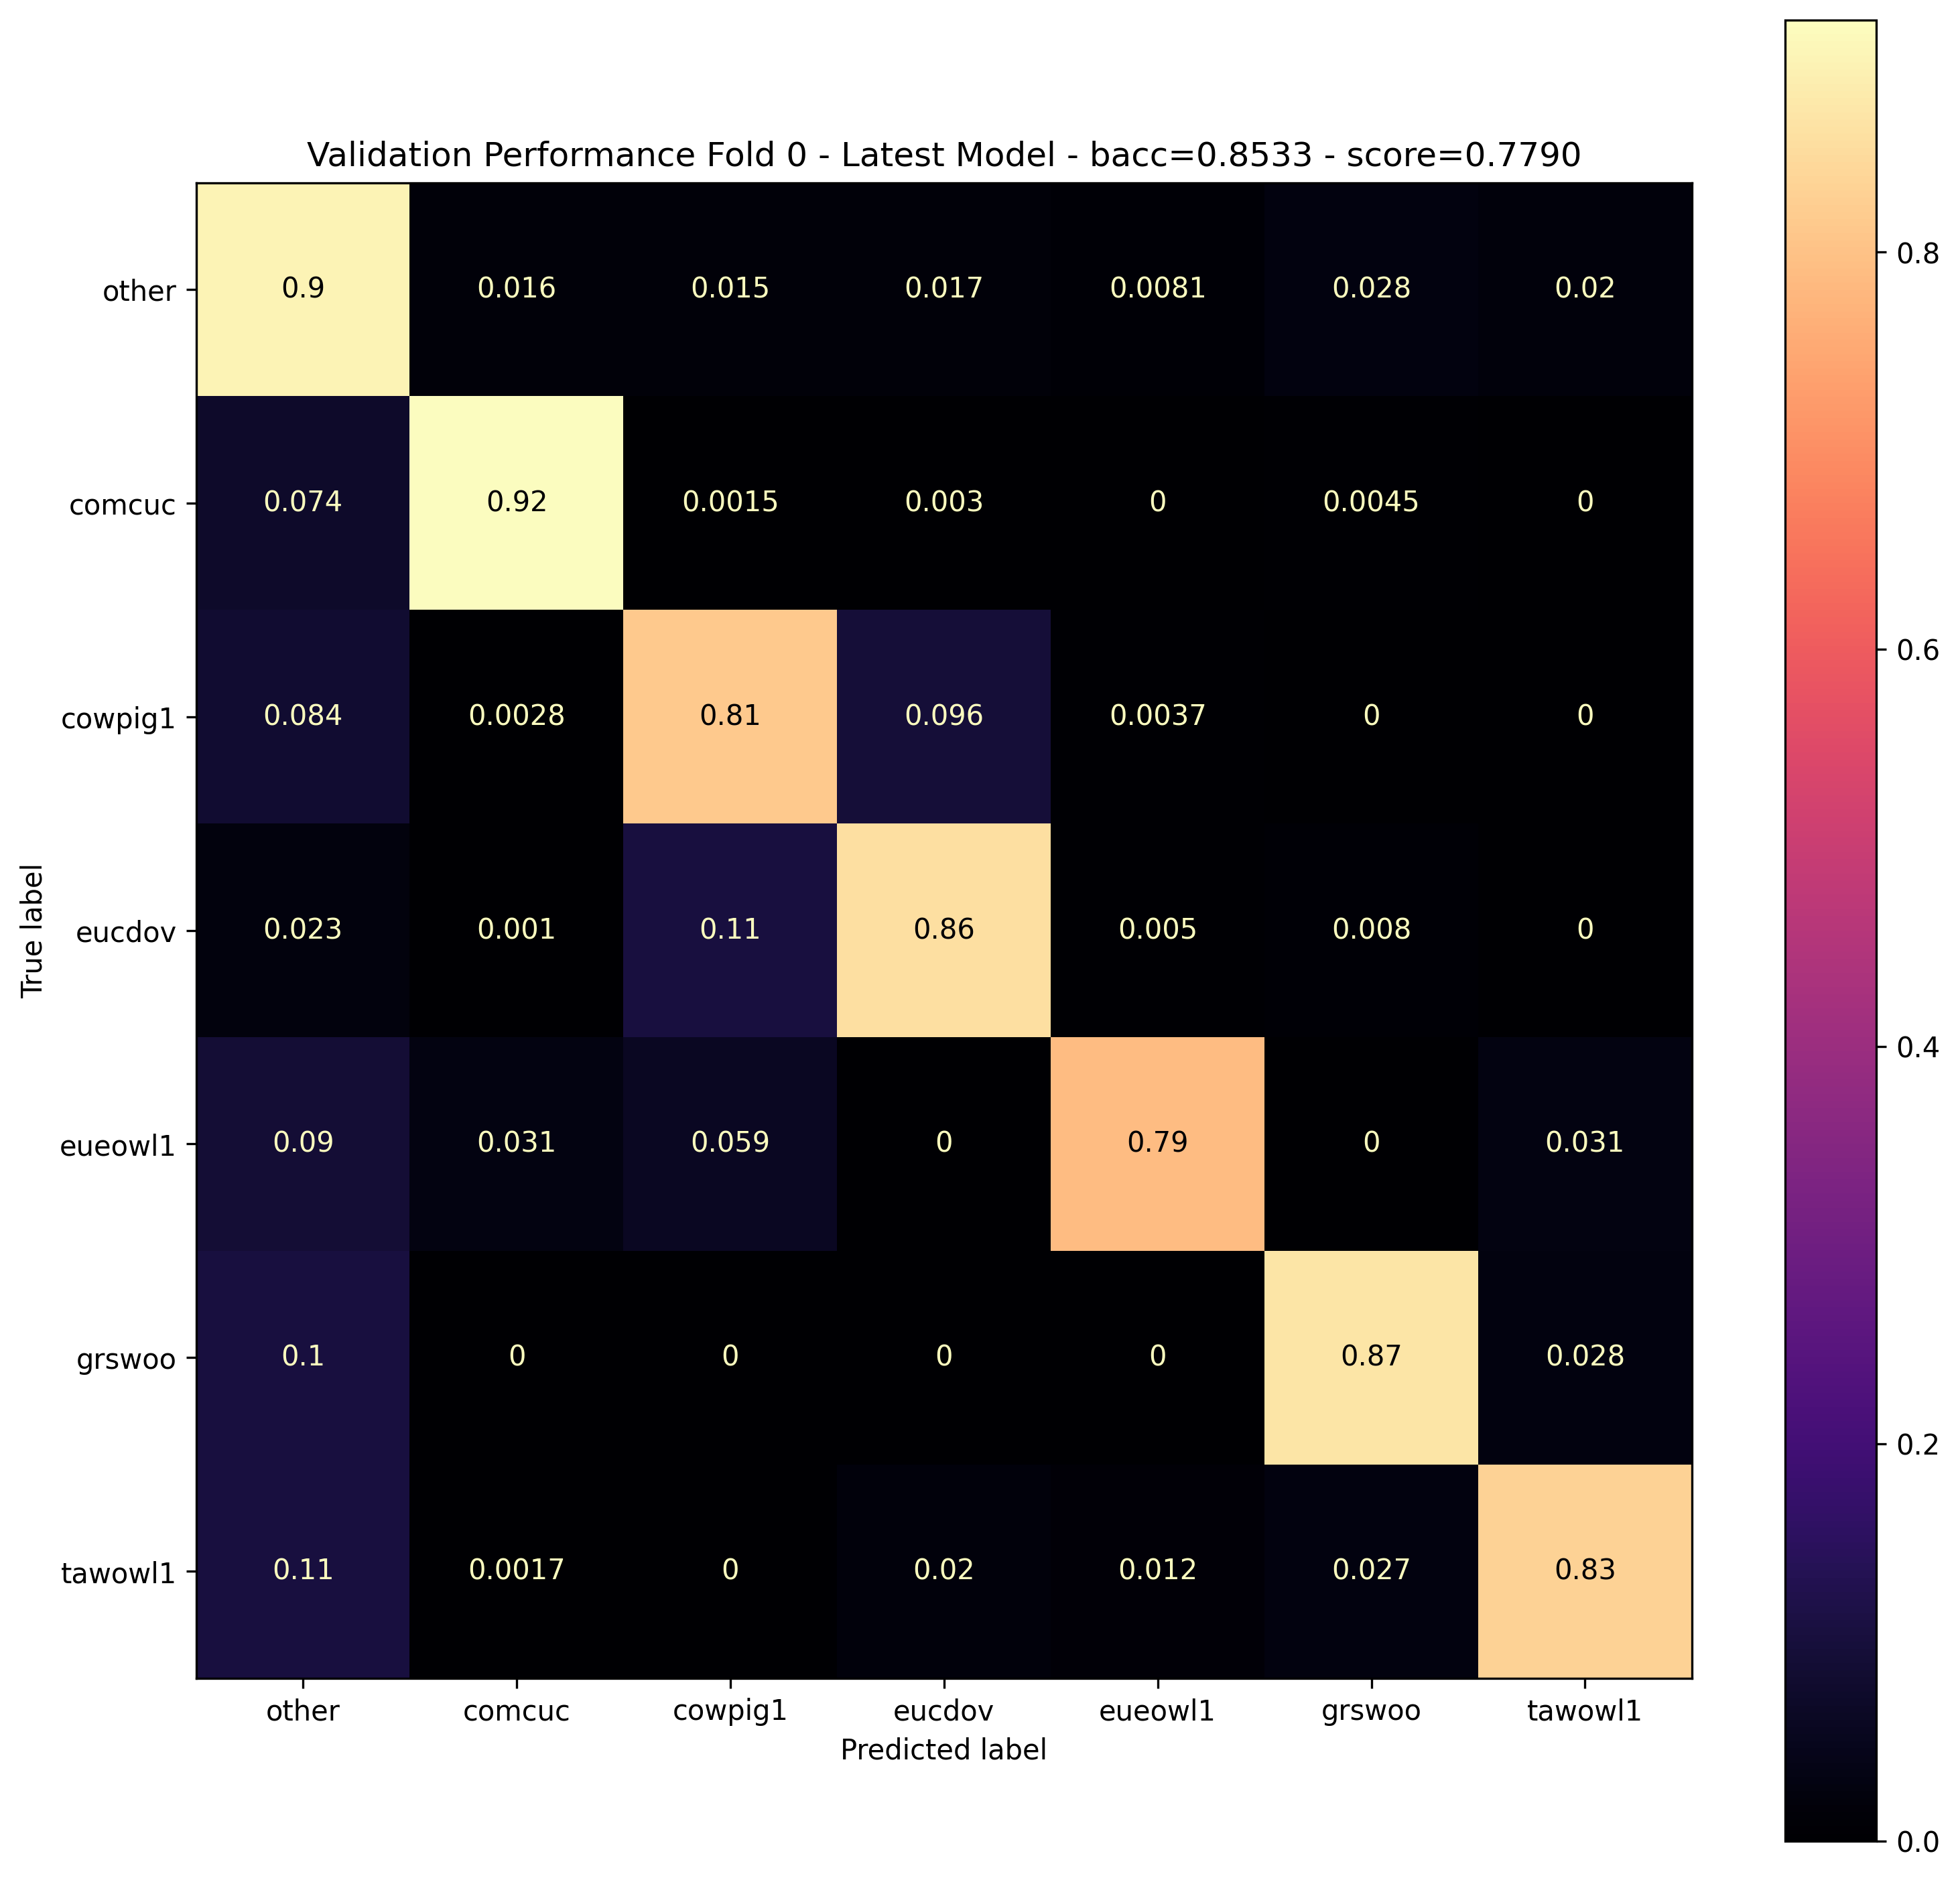

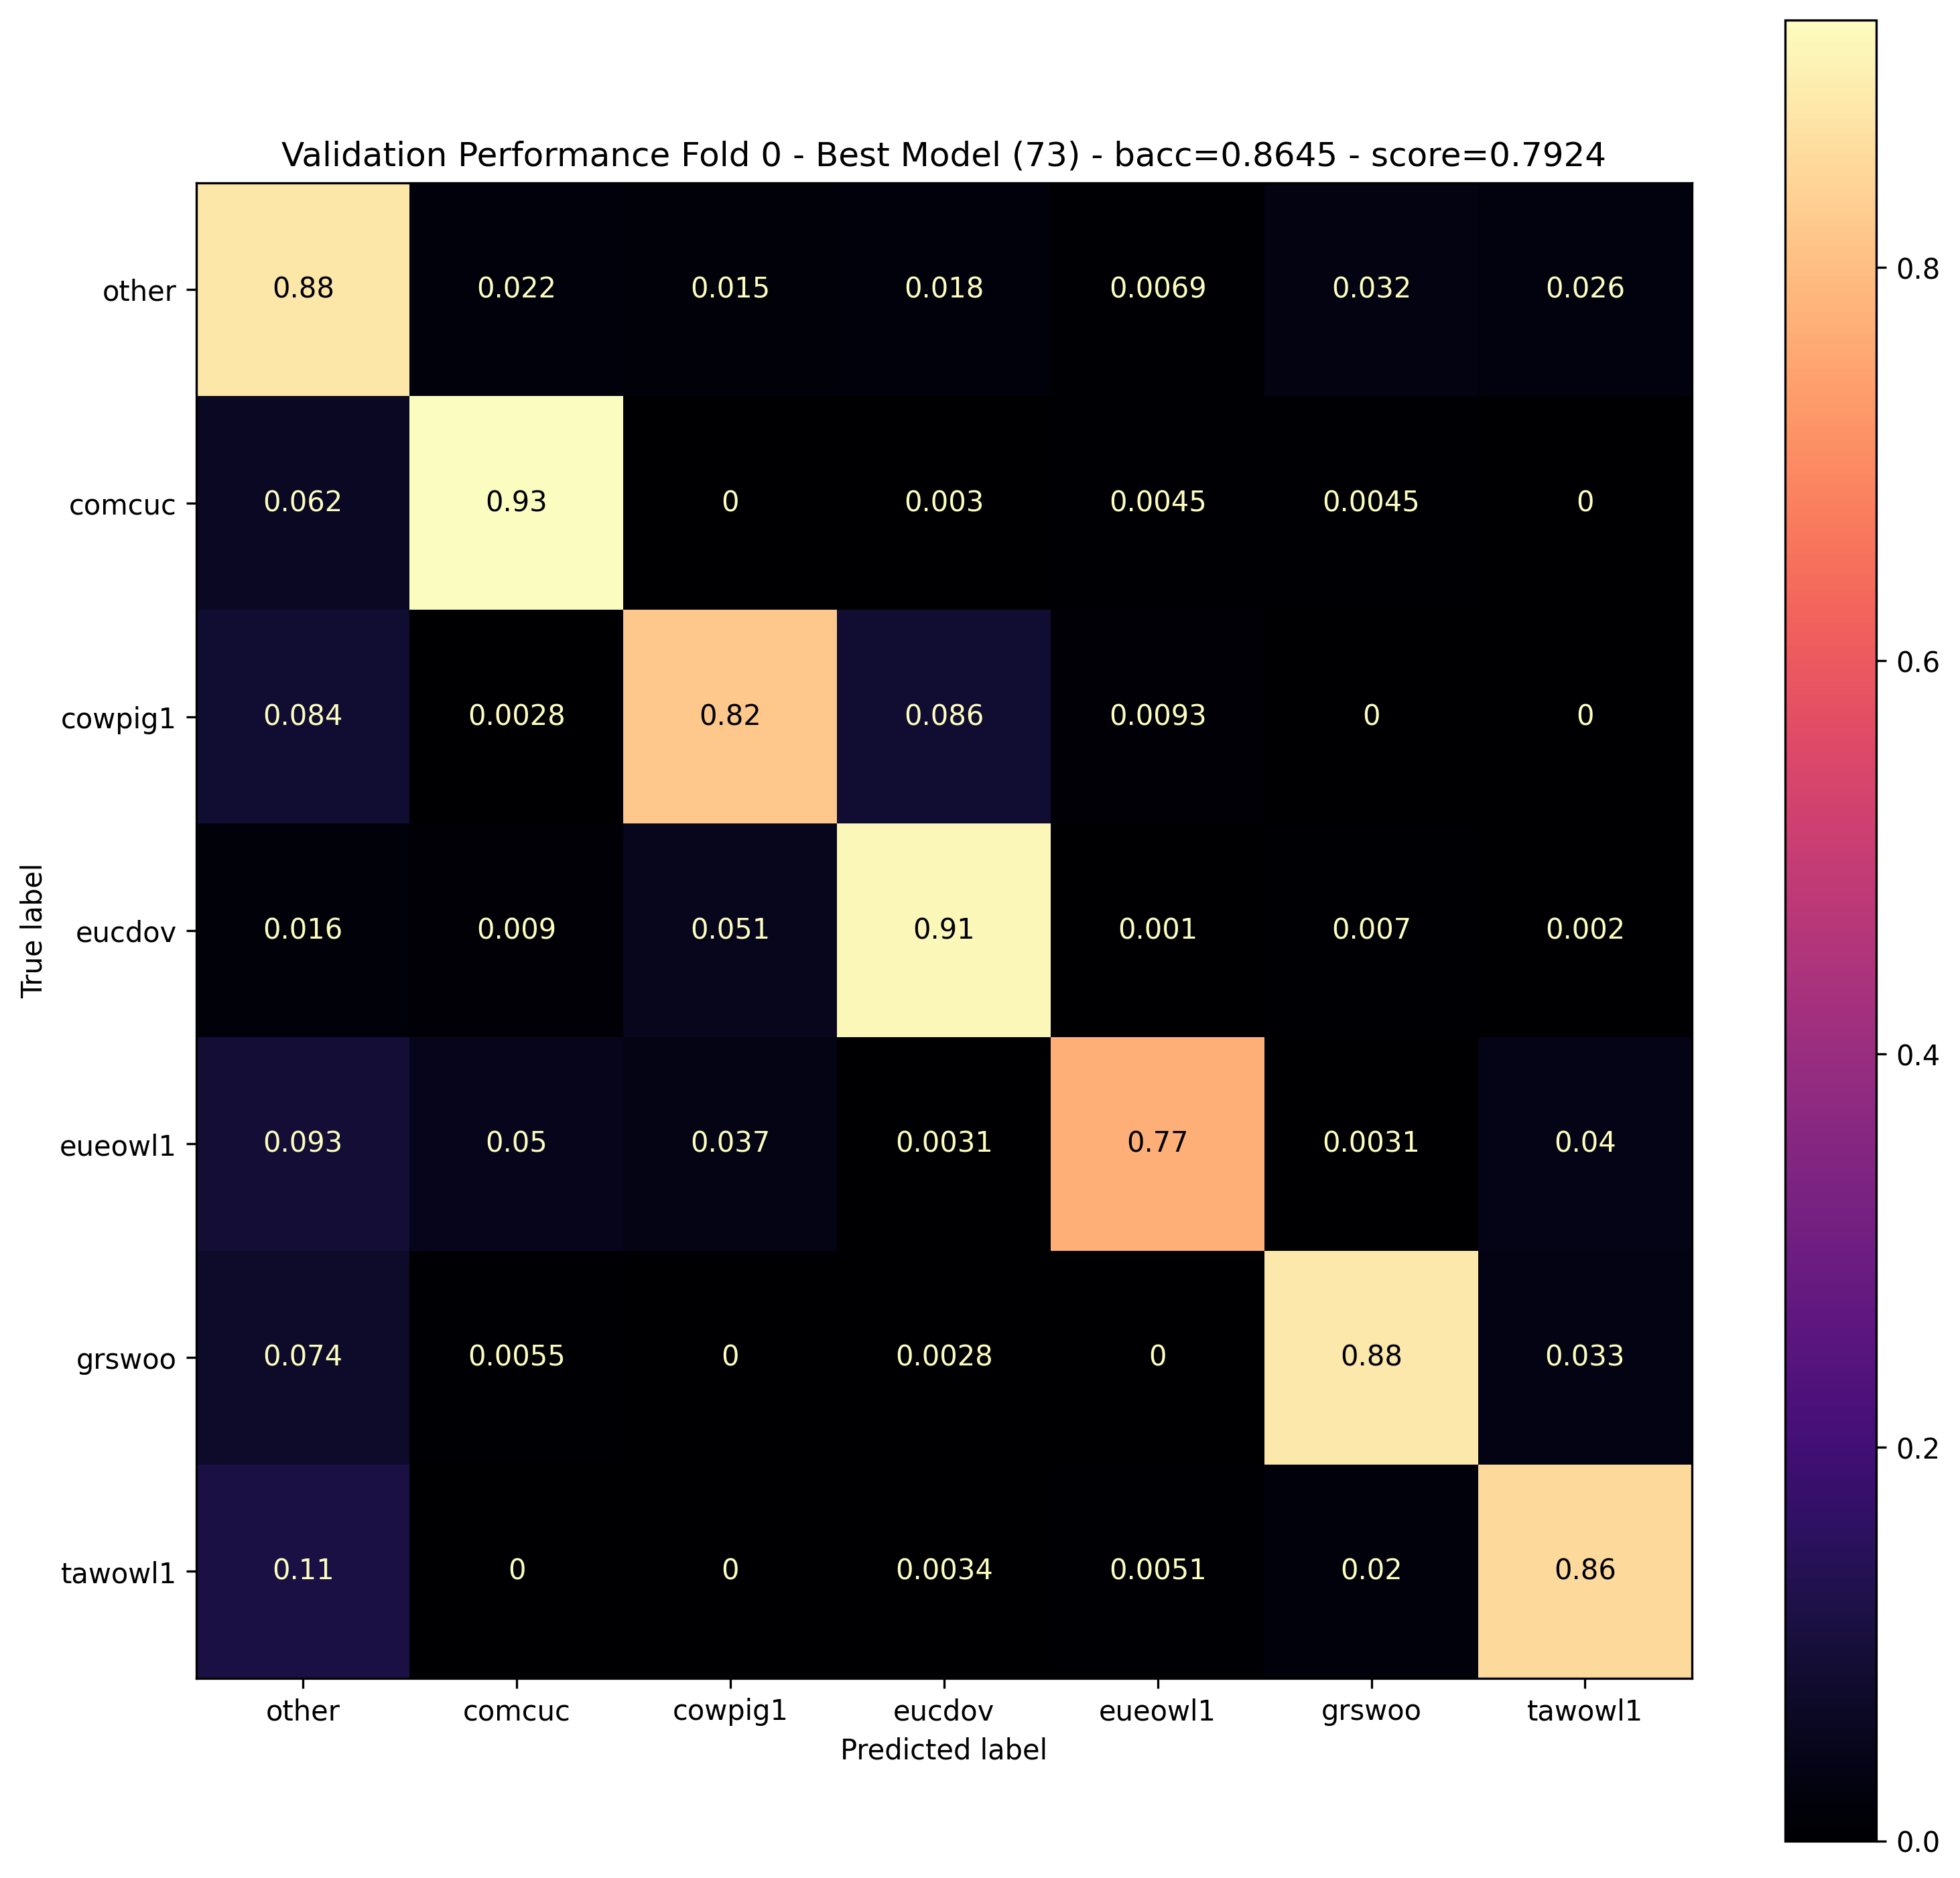

CV Folds:  12%|█████████▉                                                                     | 1/8 [00:34<04:01, 34.51s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-0-best eval-score=0.7924"



Executing CV for fold 1
Training fold 1


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74991,  5286,  7730,  6899,  2023,  4489,  3582]
eval label counts  = [10367,   547,  1224,  1299,   301,   622,   640]

balancing loss weights                    = [ 1.00, 14.19,  9.70, 10.87, 37.07, 16.71, 20.94]
balancing eval loss weights (theoretical) = [ 1.00, 18.95,  8.47,  7.98, 34.44, 16.67, 16.20]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000012, num_samples = 105000, num_correct = 19456, acc = 0.185295, bacc = 0.168934, score = -0.263049
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000122, num_samples

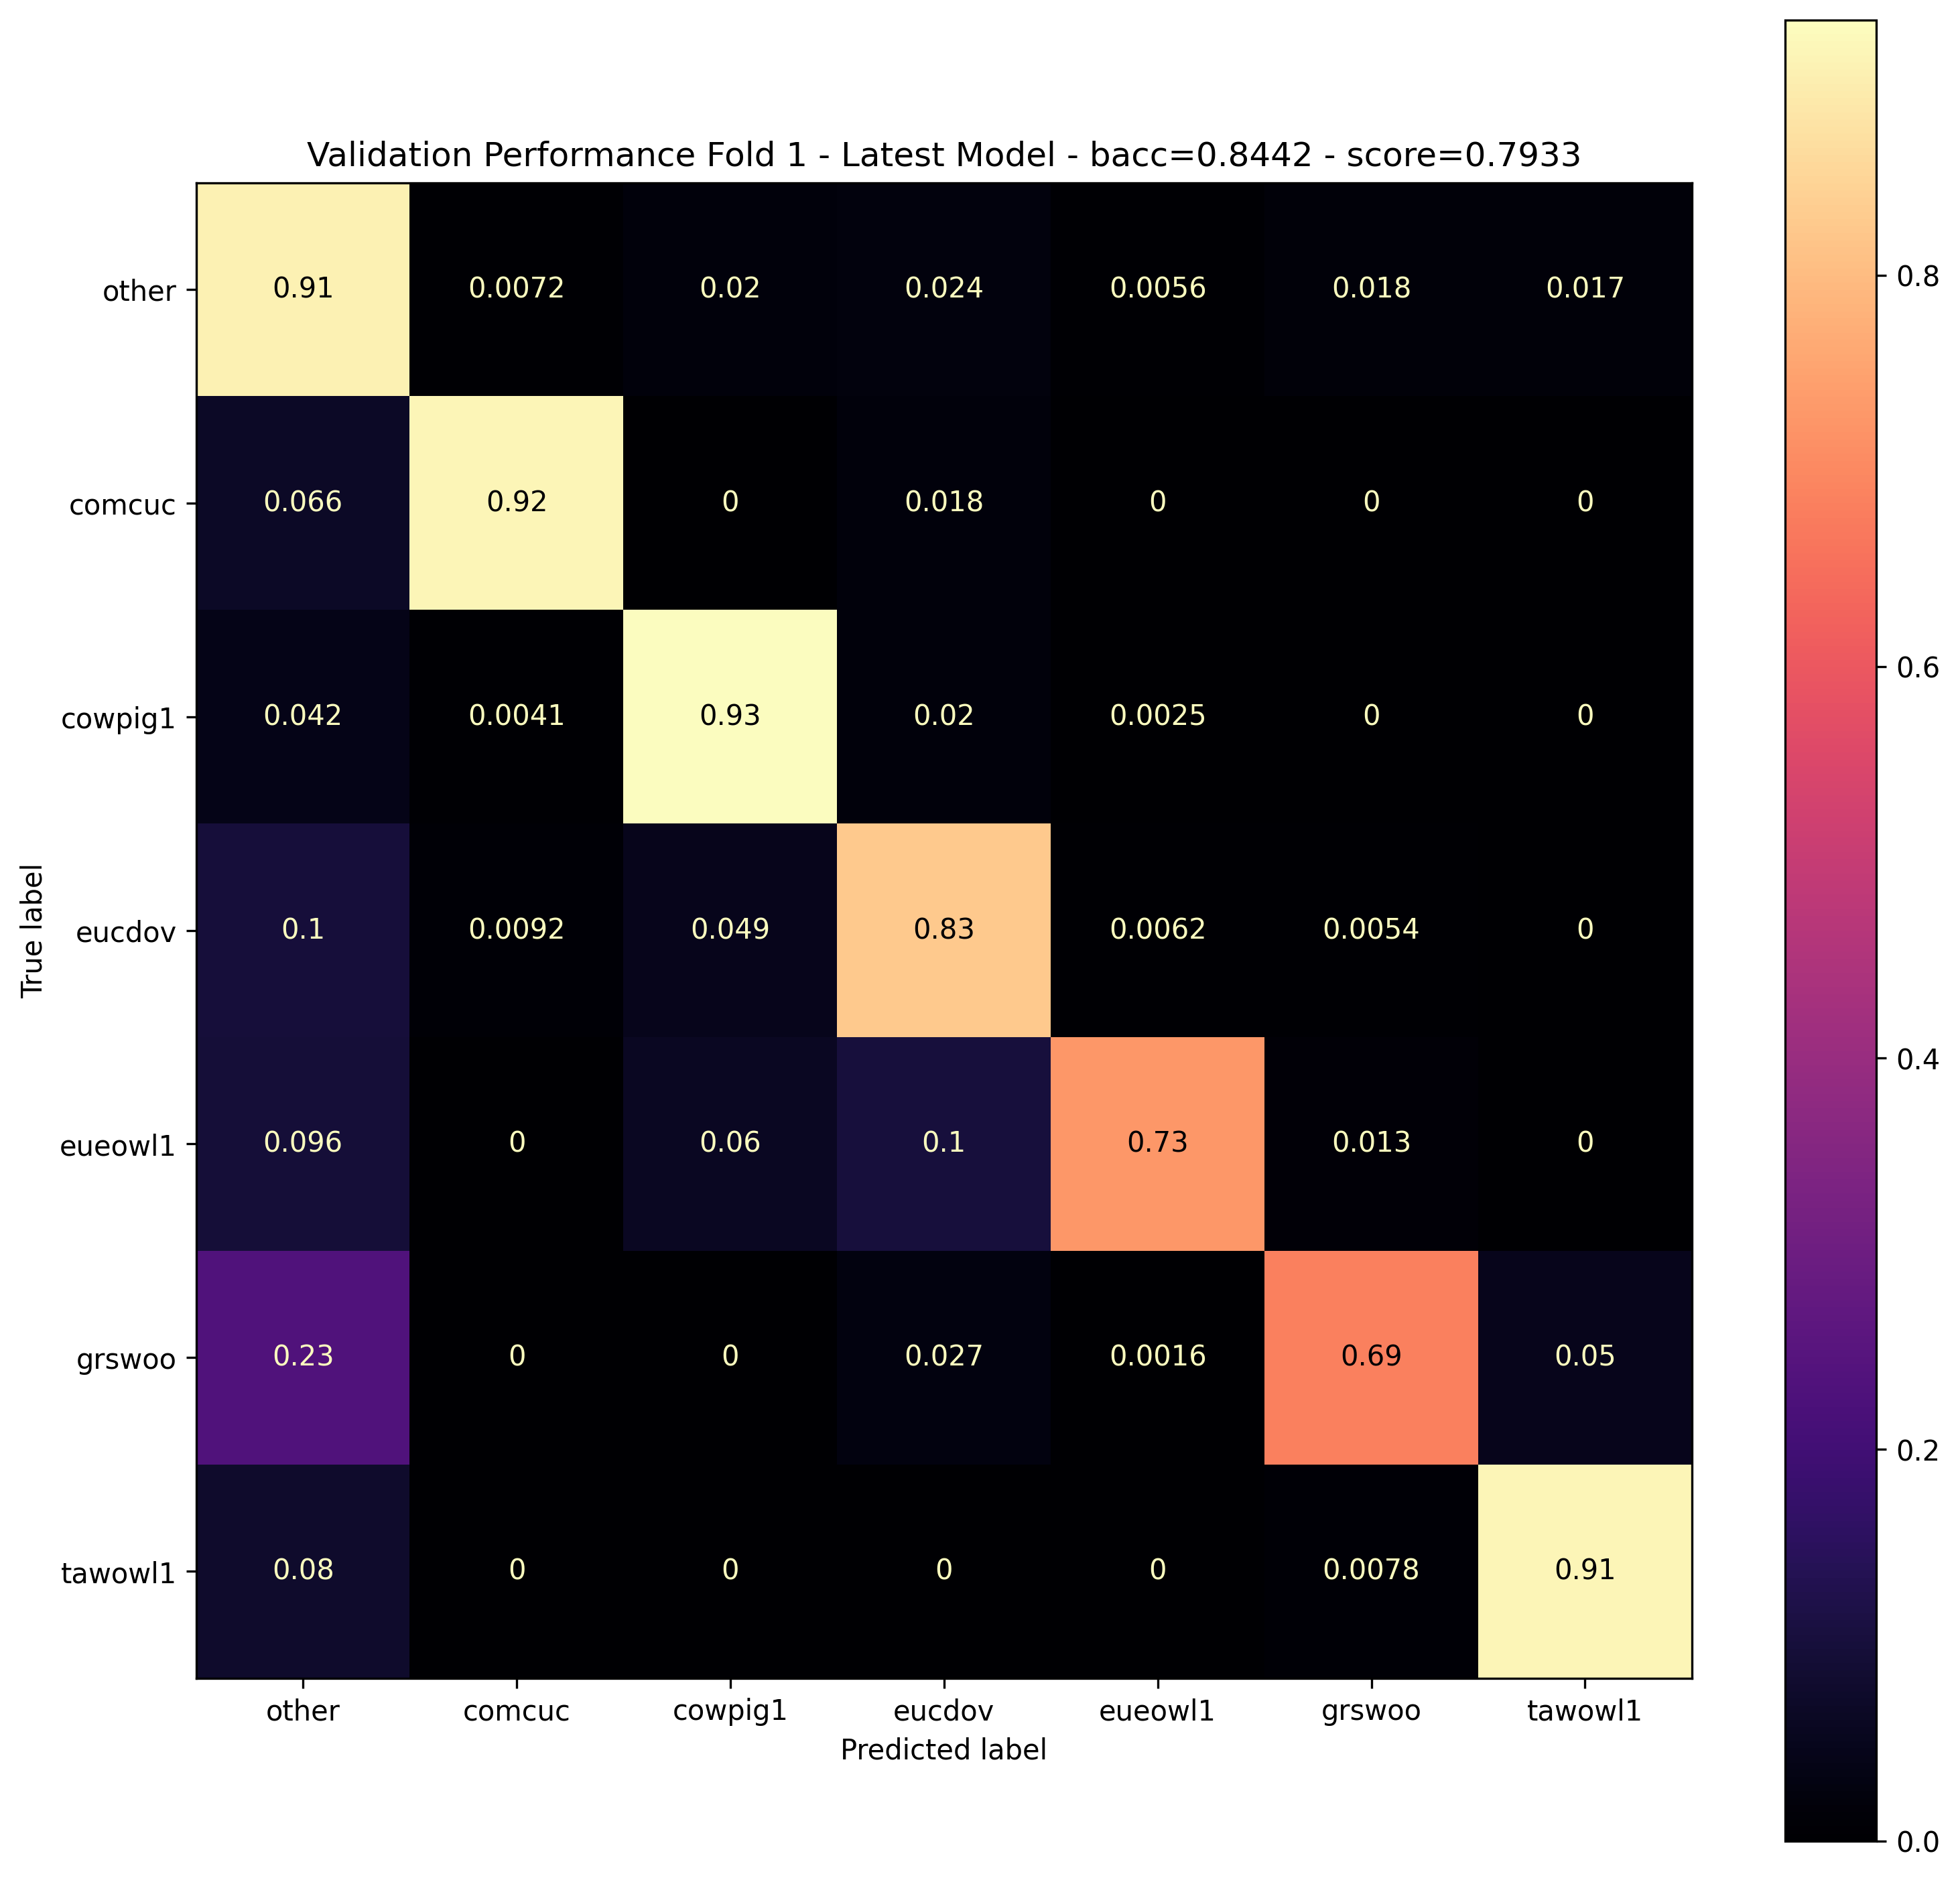

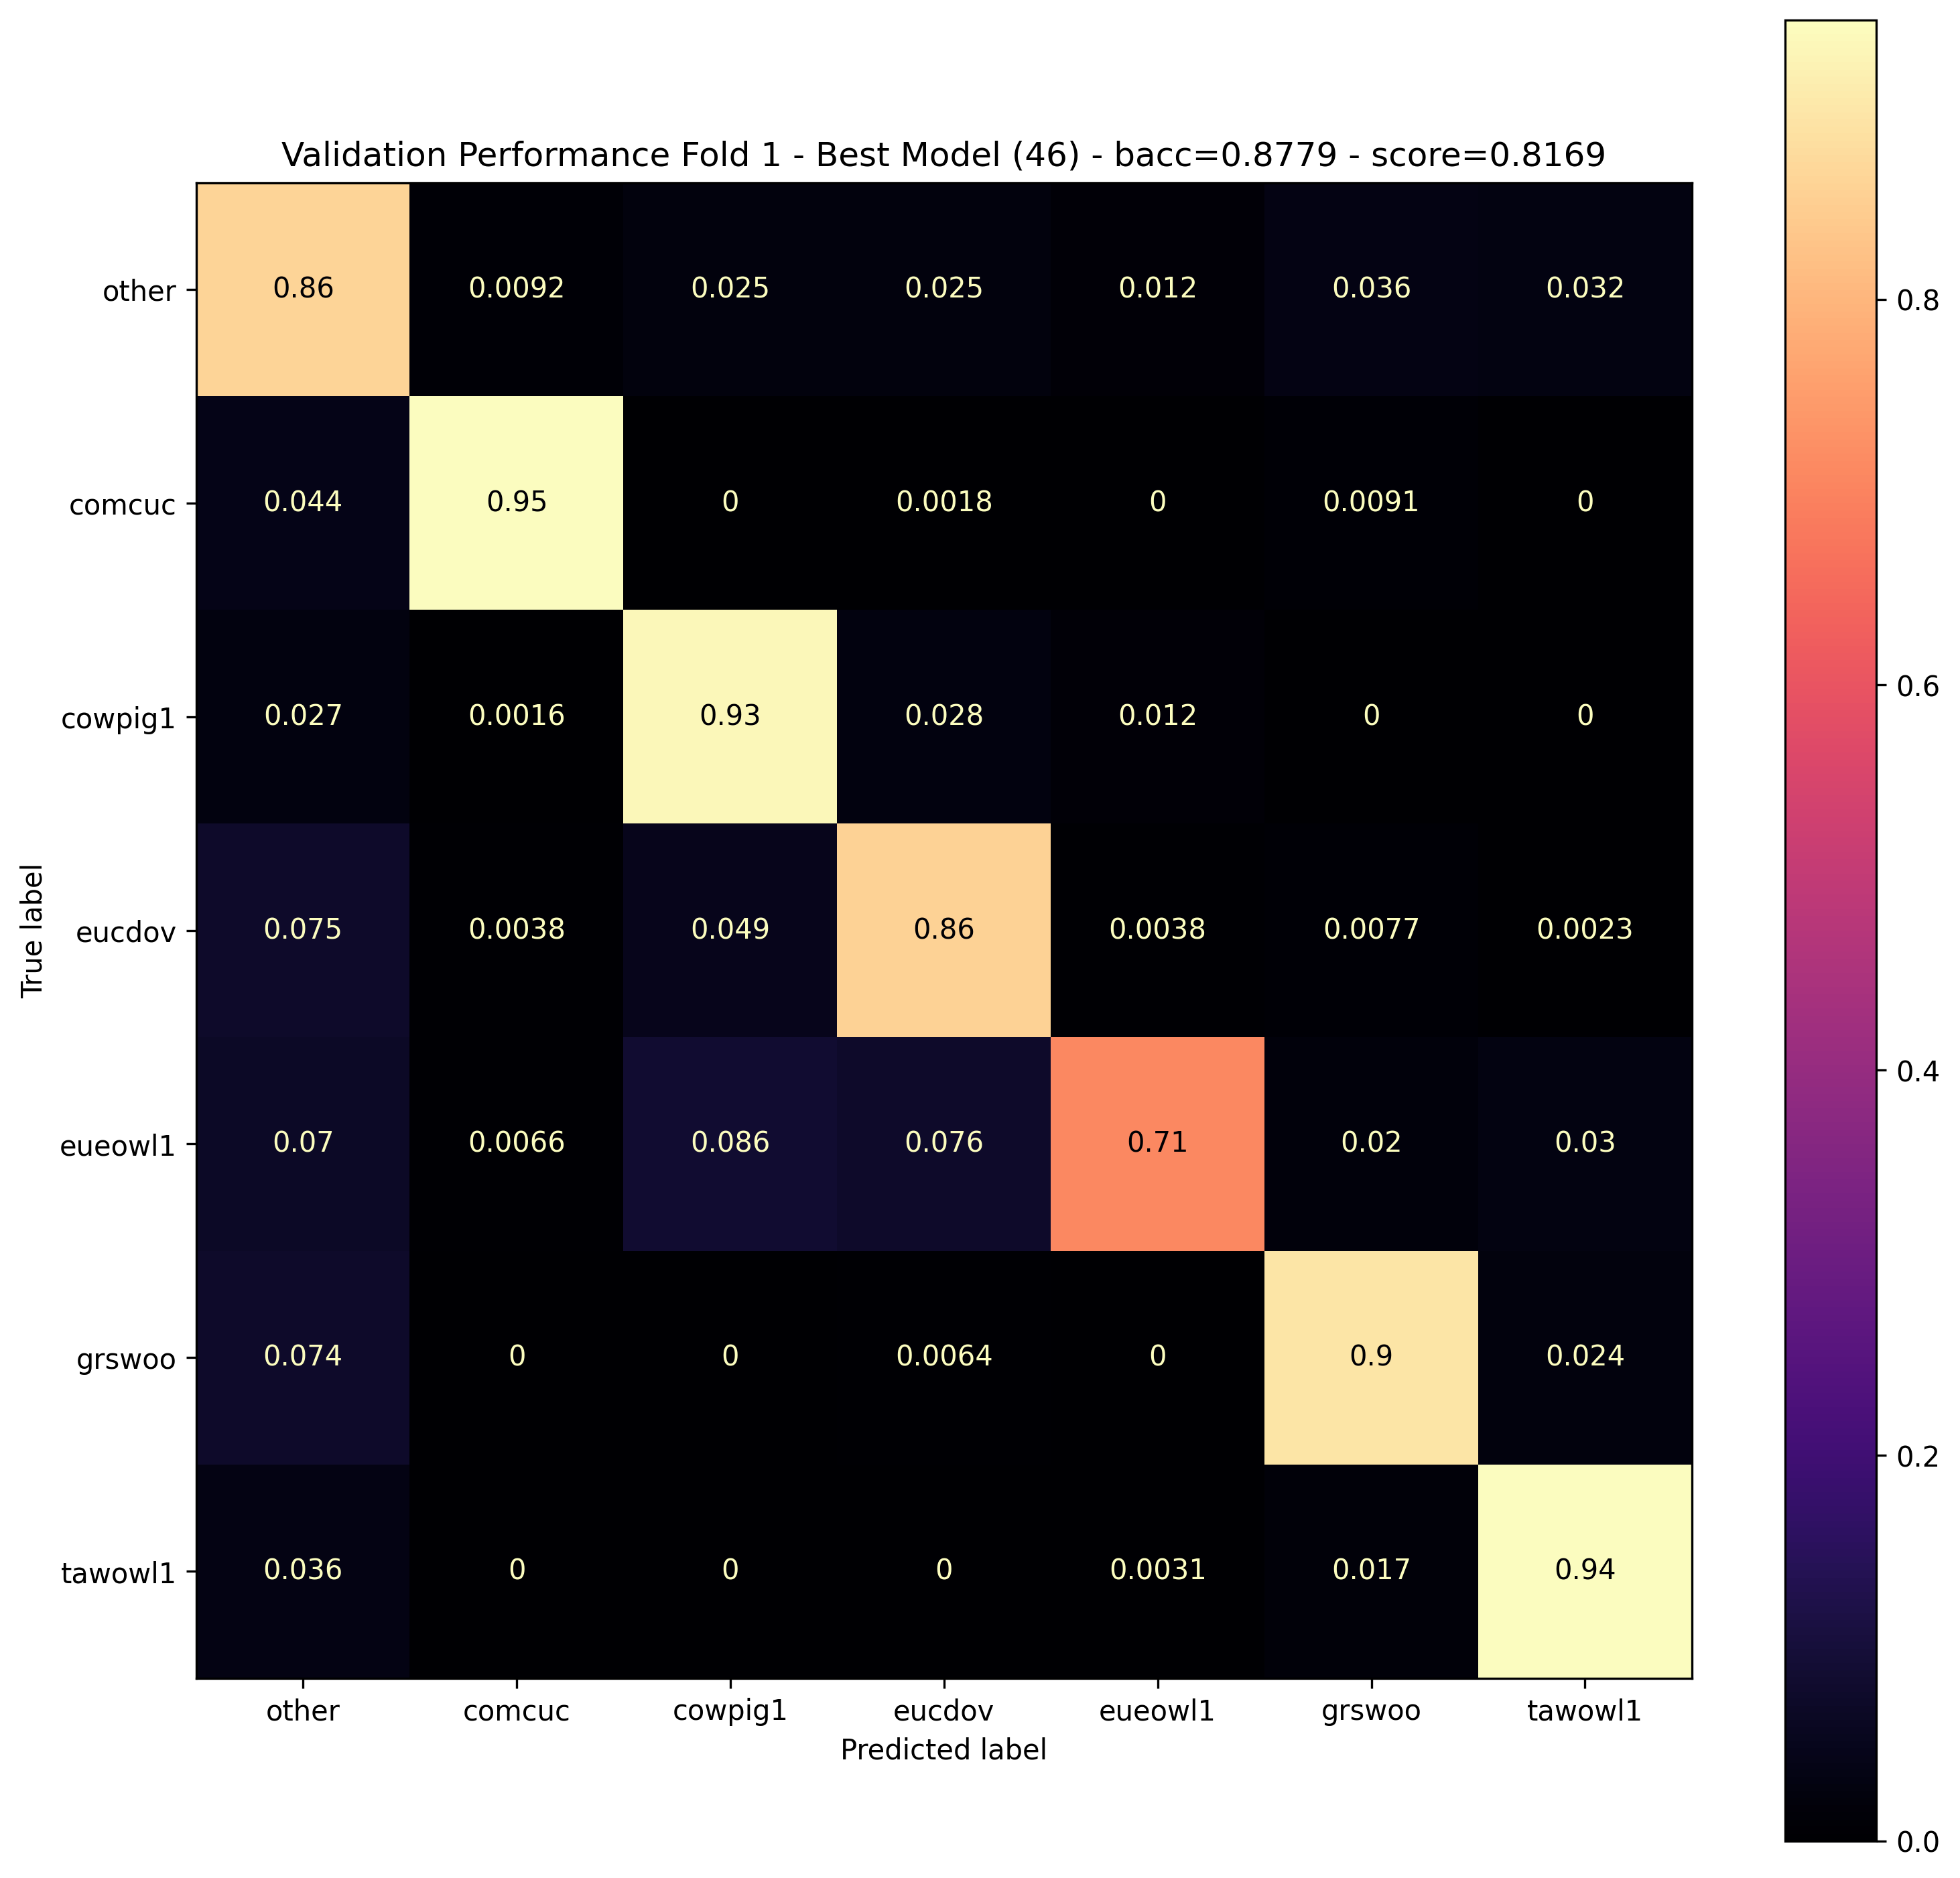

CV Folds:  25%|███████████████████▊                                                           | 2/8 [01:05<03:15, 32.64s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-1-best eval-score=0.8169"



Executing CV for fold 2
Training fold 2


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74885,  4995,  7715,  7167,  2005,  4465,  3768]
eval label counts  = [10473,   838,  1239,  1031,   319,   646,   454]

balancing loss weights                    = [ 1.00, 14.99,  9.71, 10.45, 37.35, 16.77, 19.87]
balancing eval loss weights (theoretical) = [ 1.00, 12.50,  8.45, 10.16, 32.83, 16.21, 23.07]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000013, num_samples = 105000, num_correct = 14177, acc = 0.135019, bacc = 0.159043, score = -0.316344
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000126, num_samples

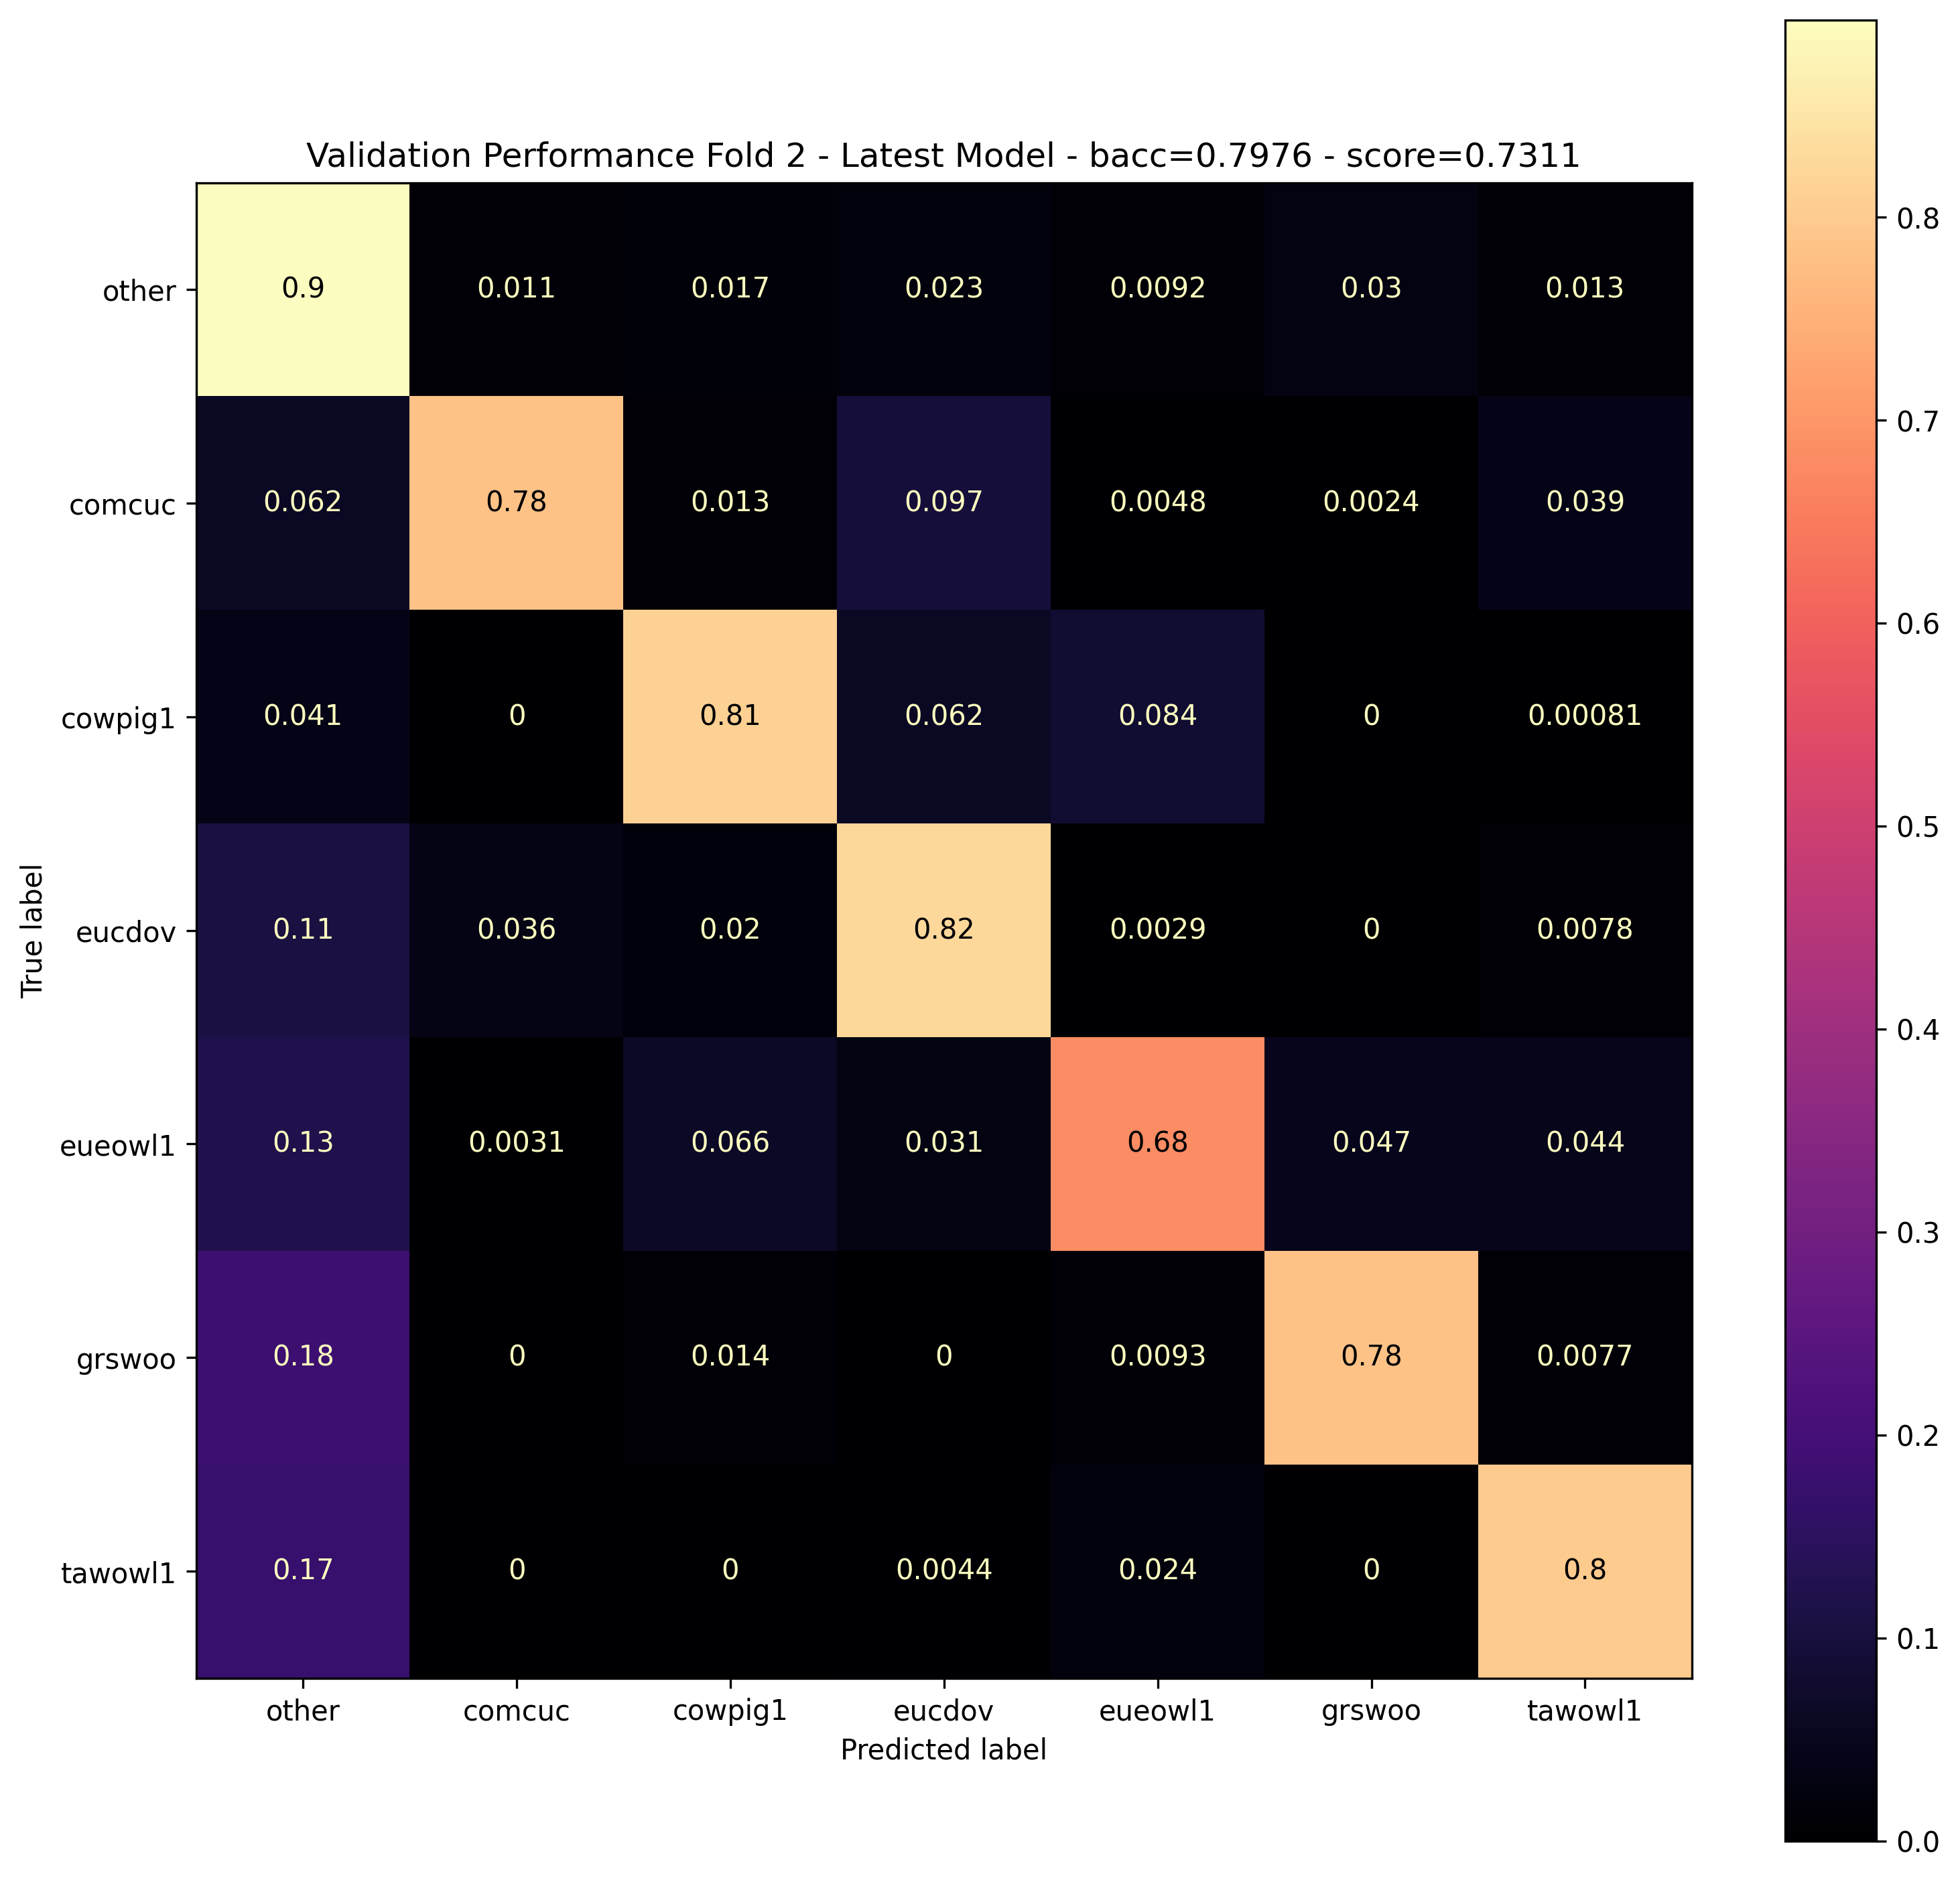

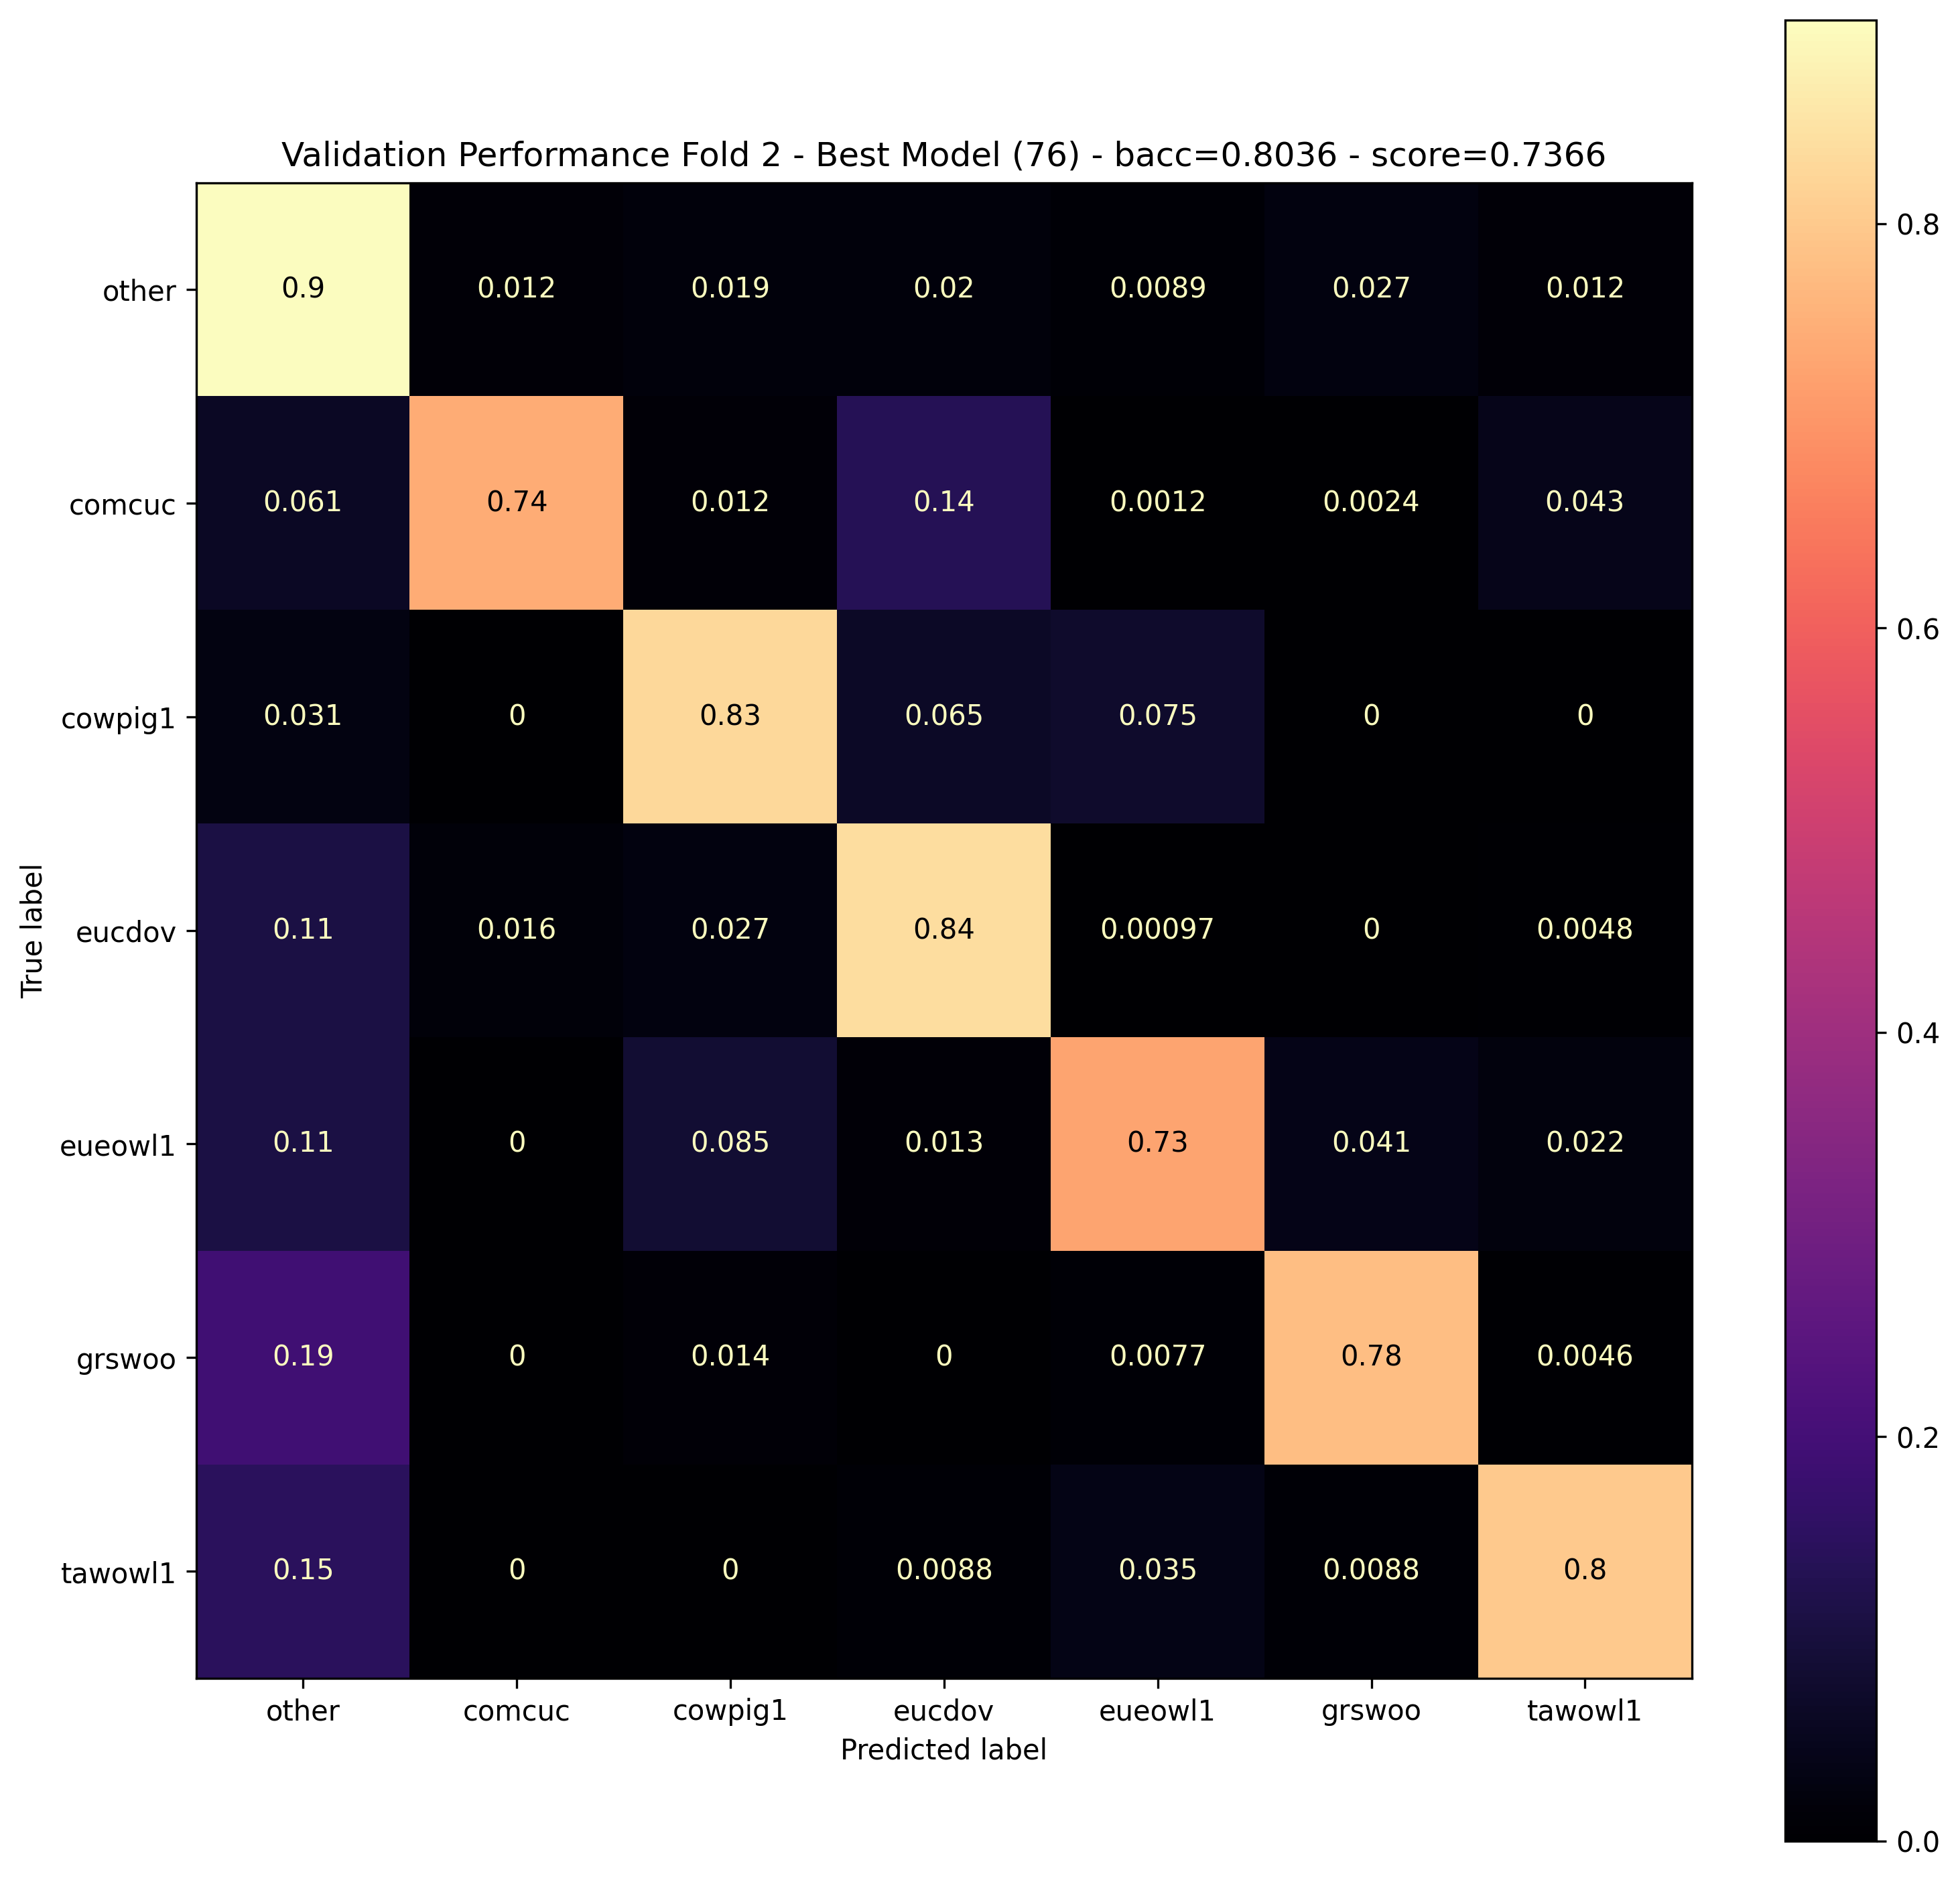

CV Folds:  38%|█████████████████████████████▋                                                 | 3/8 [01:39<02:46, 33.21s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-2-best eval-score=0.7366"



Executing CV for fold 3
Training fold 3


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74572,  4980,  7939,  7329,  2065,  4354,  3761]
eval label counts  = [10786,   853,  1015,   869,   259,   757,   461]

balancing loss weights                    = [ 1.00, 14.97,  9.39, 10.17, 36.11, 17.13, 19.83]
balancing eval loss weights (theoretical) = [ 1.00, 12.64, 10.63, 12.41, 41.64, 14.25, 23.40]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000012, num_samples = 105000, num_correct = 34450, acc = 0.328095, bacc = 0.189153, score = -0.173367
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000122, num_samples

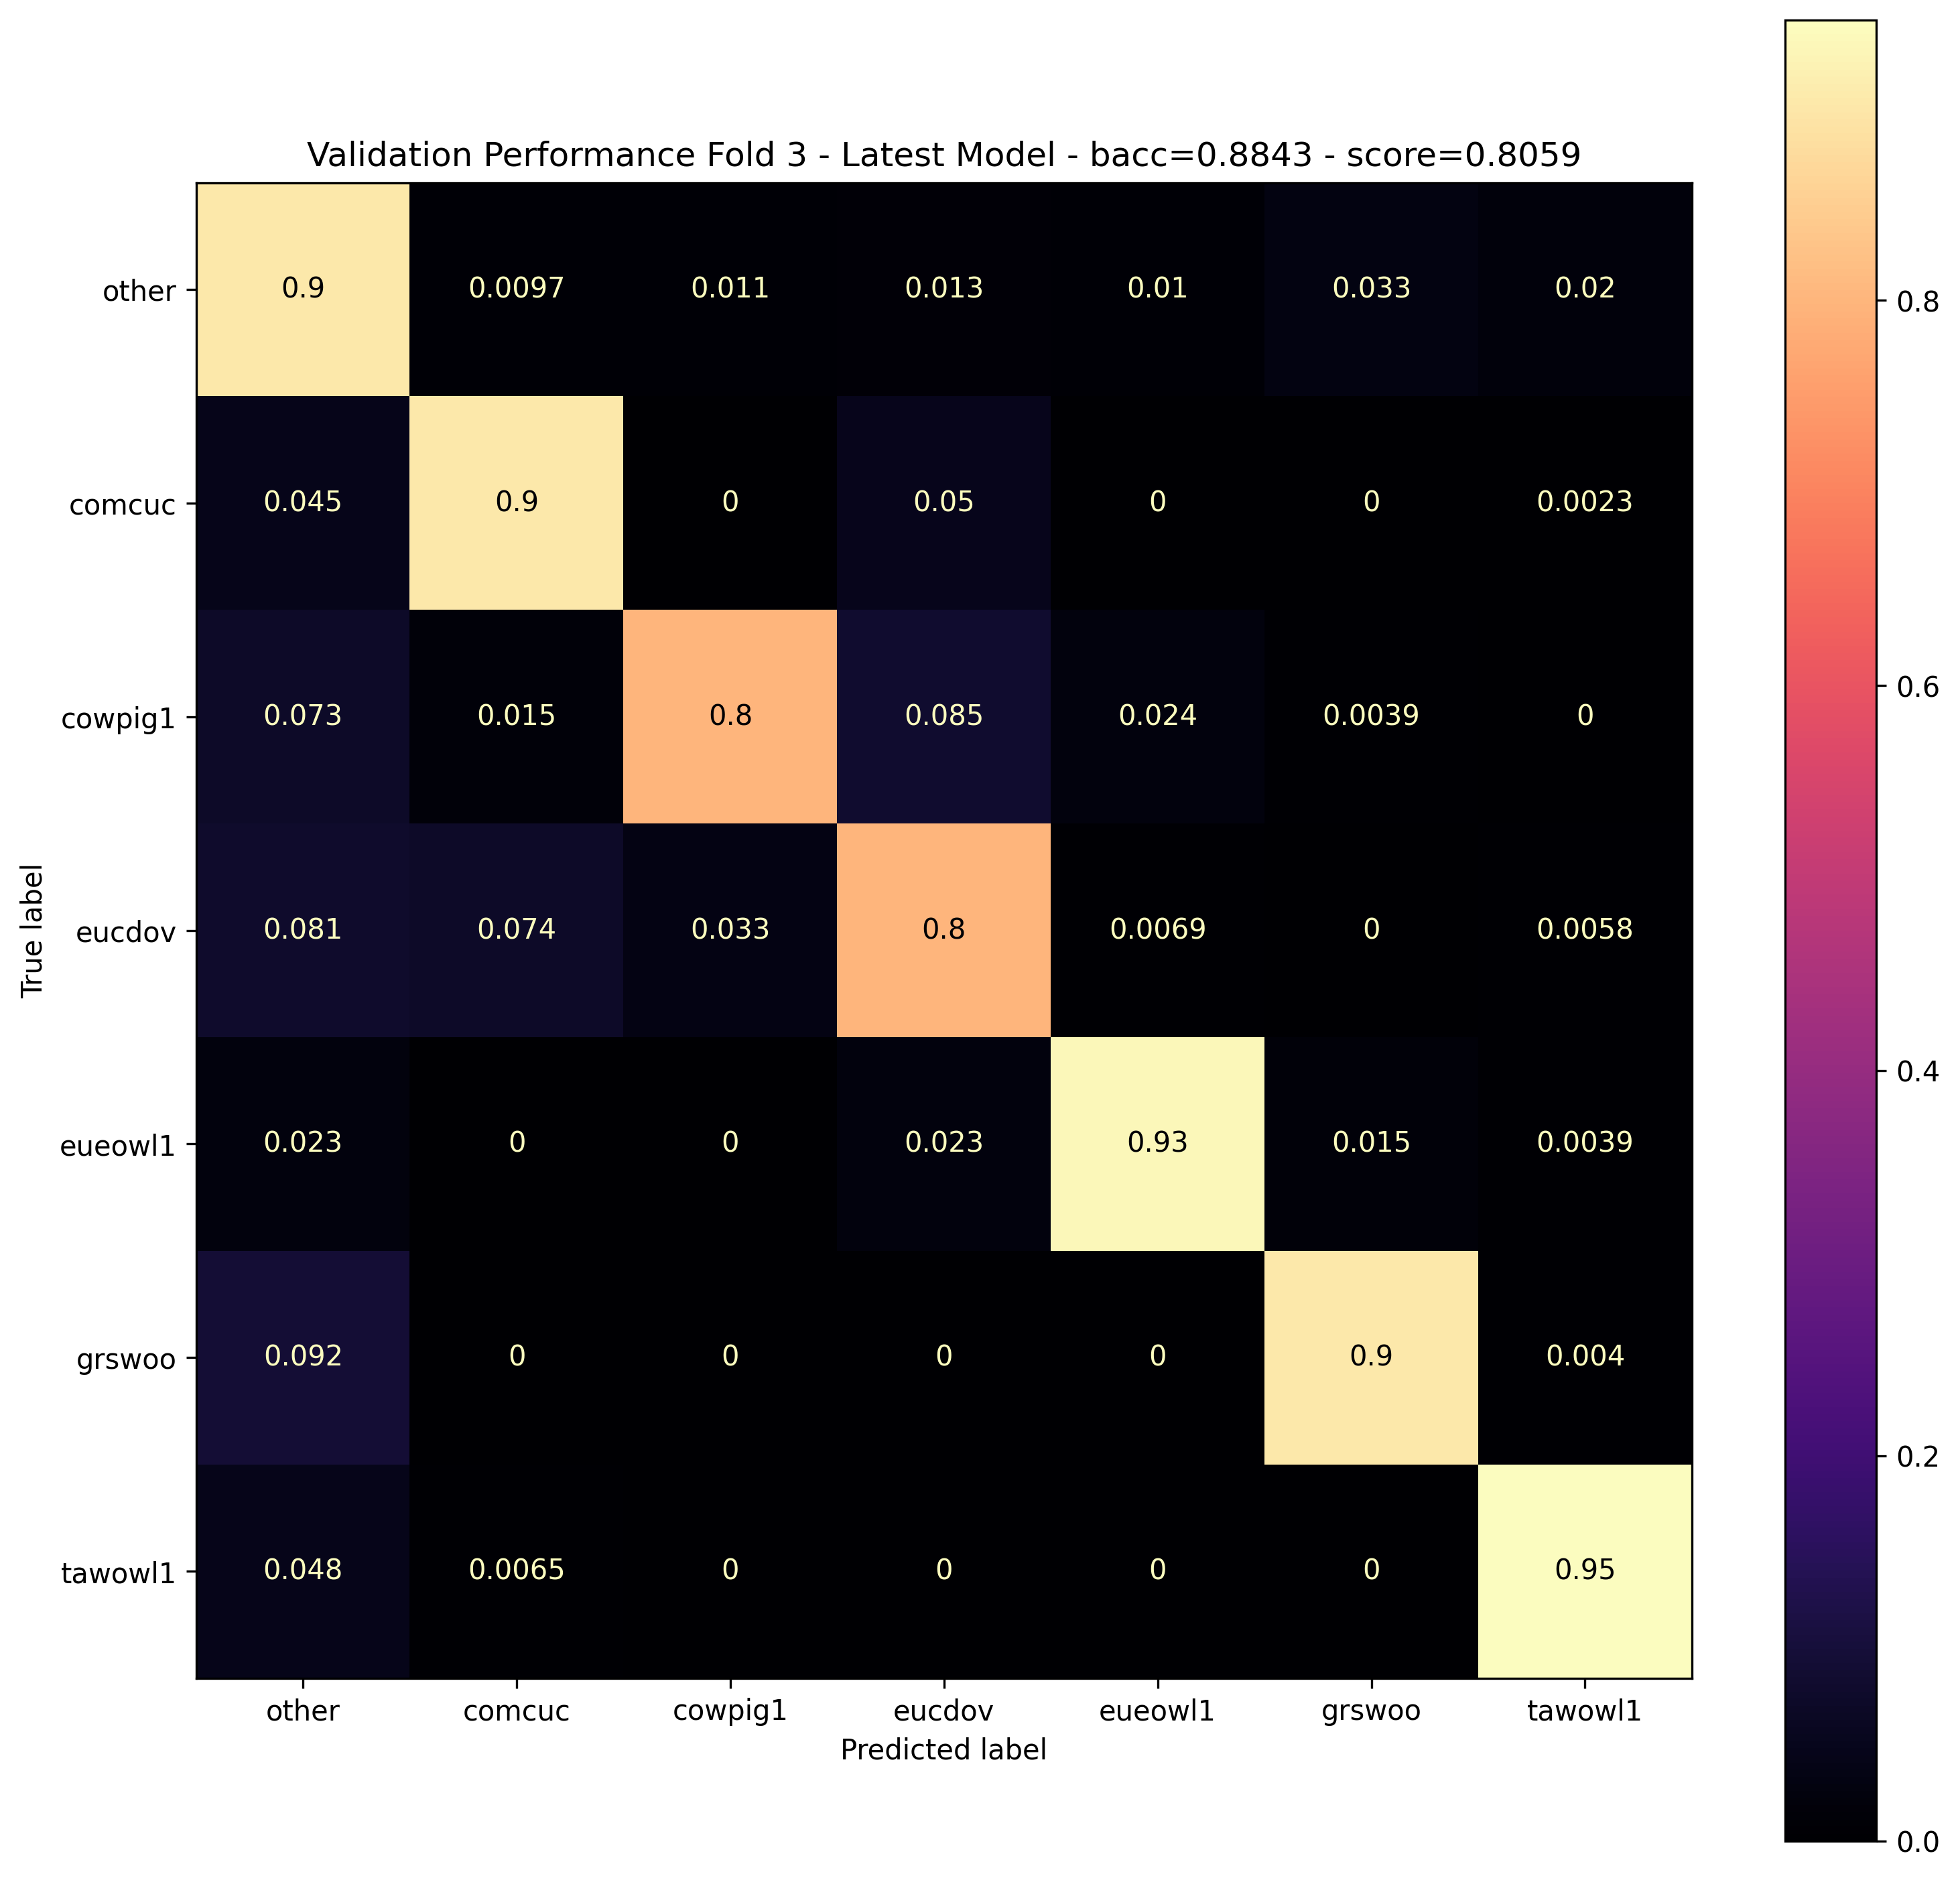

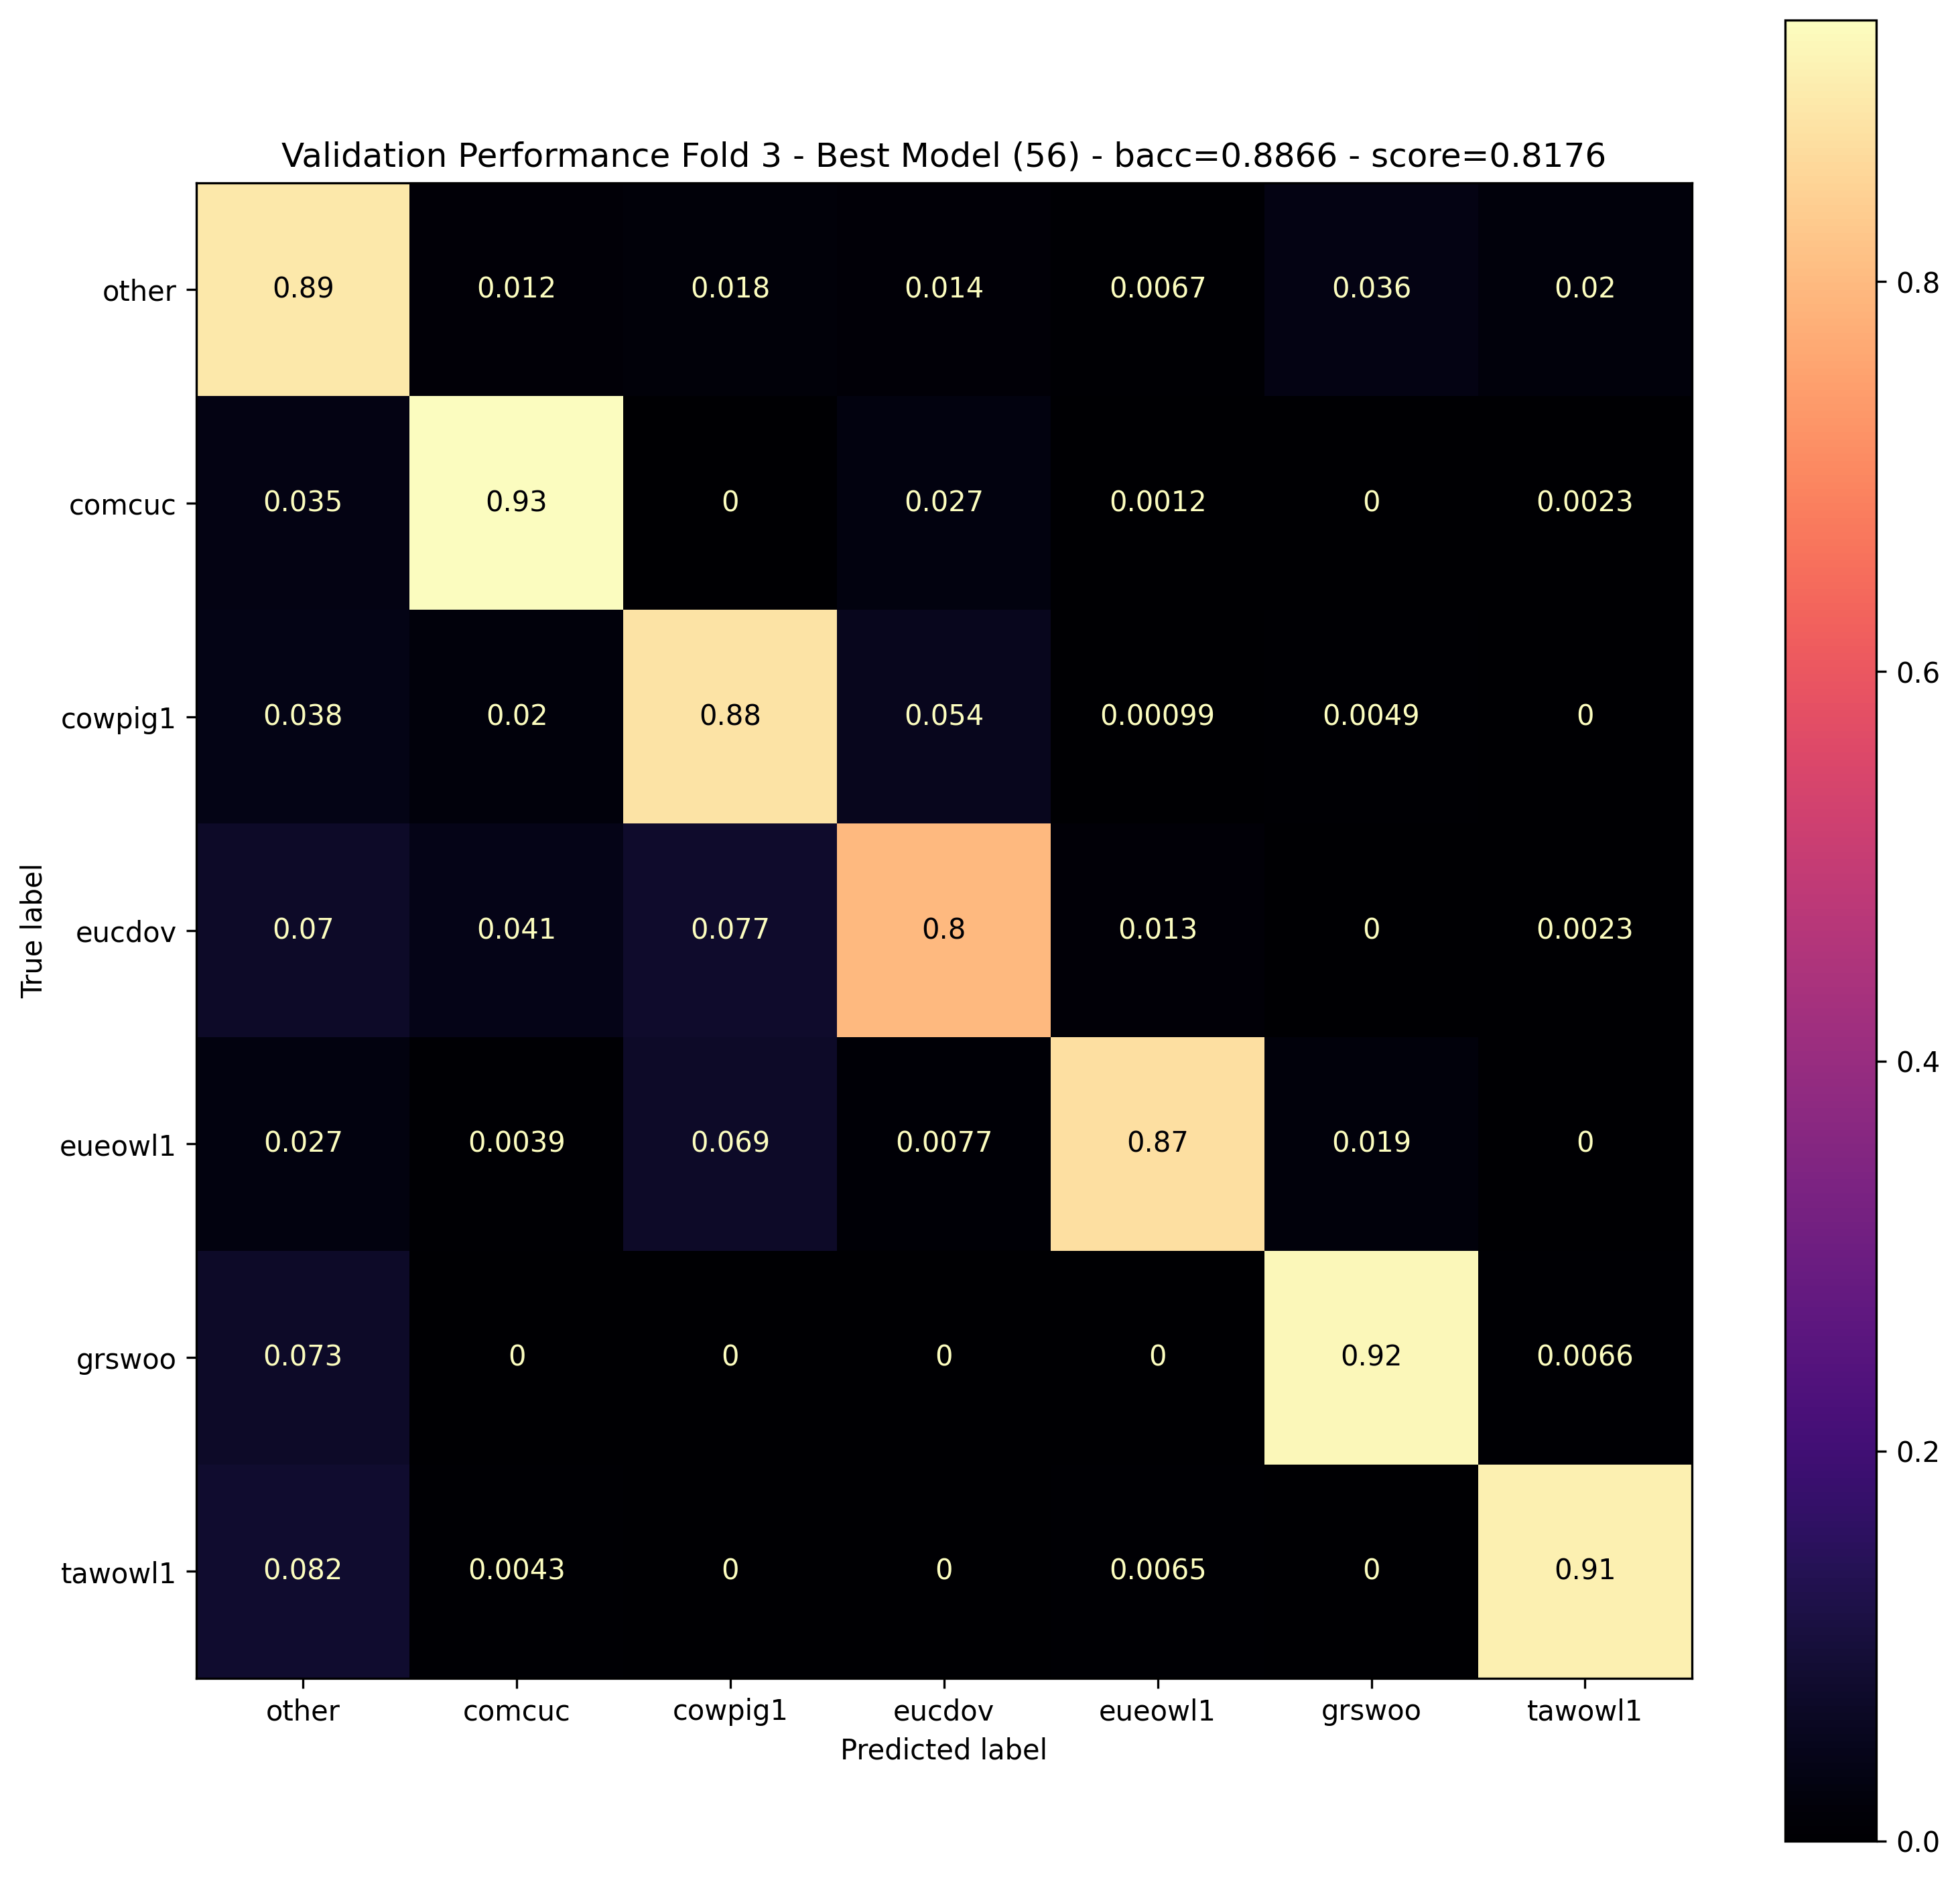

CV Folds:  50%|███████████████████████████████████████▌                                       | 4/8 [02:13<02:14, 33.62s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-3-best eval-score=0.8176"



Executing CV for fold 4
Training fold 4


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74535,  5083,  7583,  7407,  1942,  4654,  3796]
eval label counts  = [10823,   750,  1371,   791,   382,   457,   426]

balancing loss weights                    = [ 1.00, 14.66,  9.83, 10.06, 38.38, 16.02, 19.64]
balancing eval loss weights (theoretical) = [ 1.00, 14.43,  7.89, 13.68, 28.33, 23.68, 25.41]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000013, num_samples = 105000, num_correct = 32311, acc = 0.307724, bacc = 0.158621, score = -0.250986
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000122, num_samples

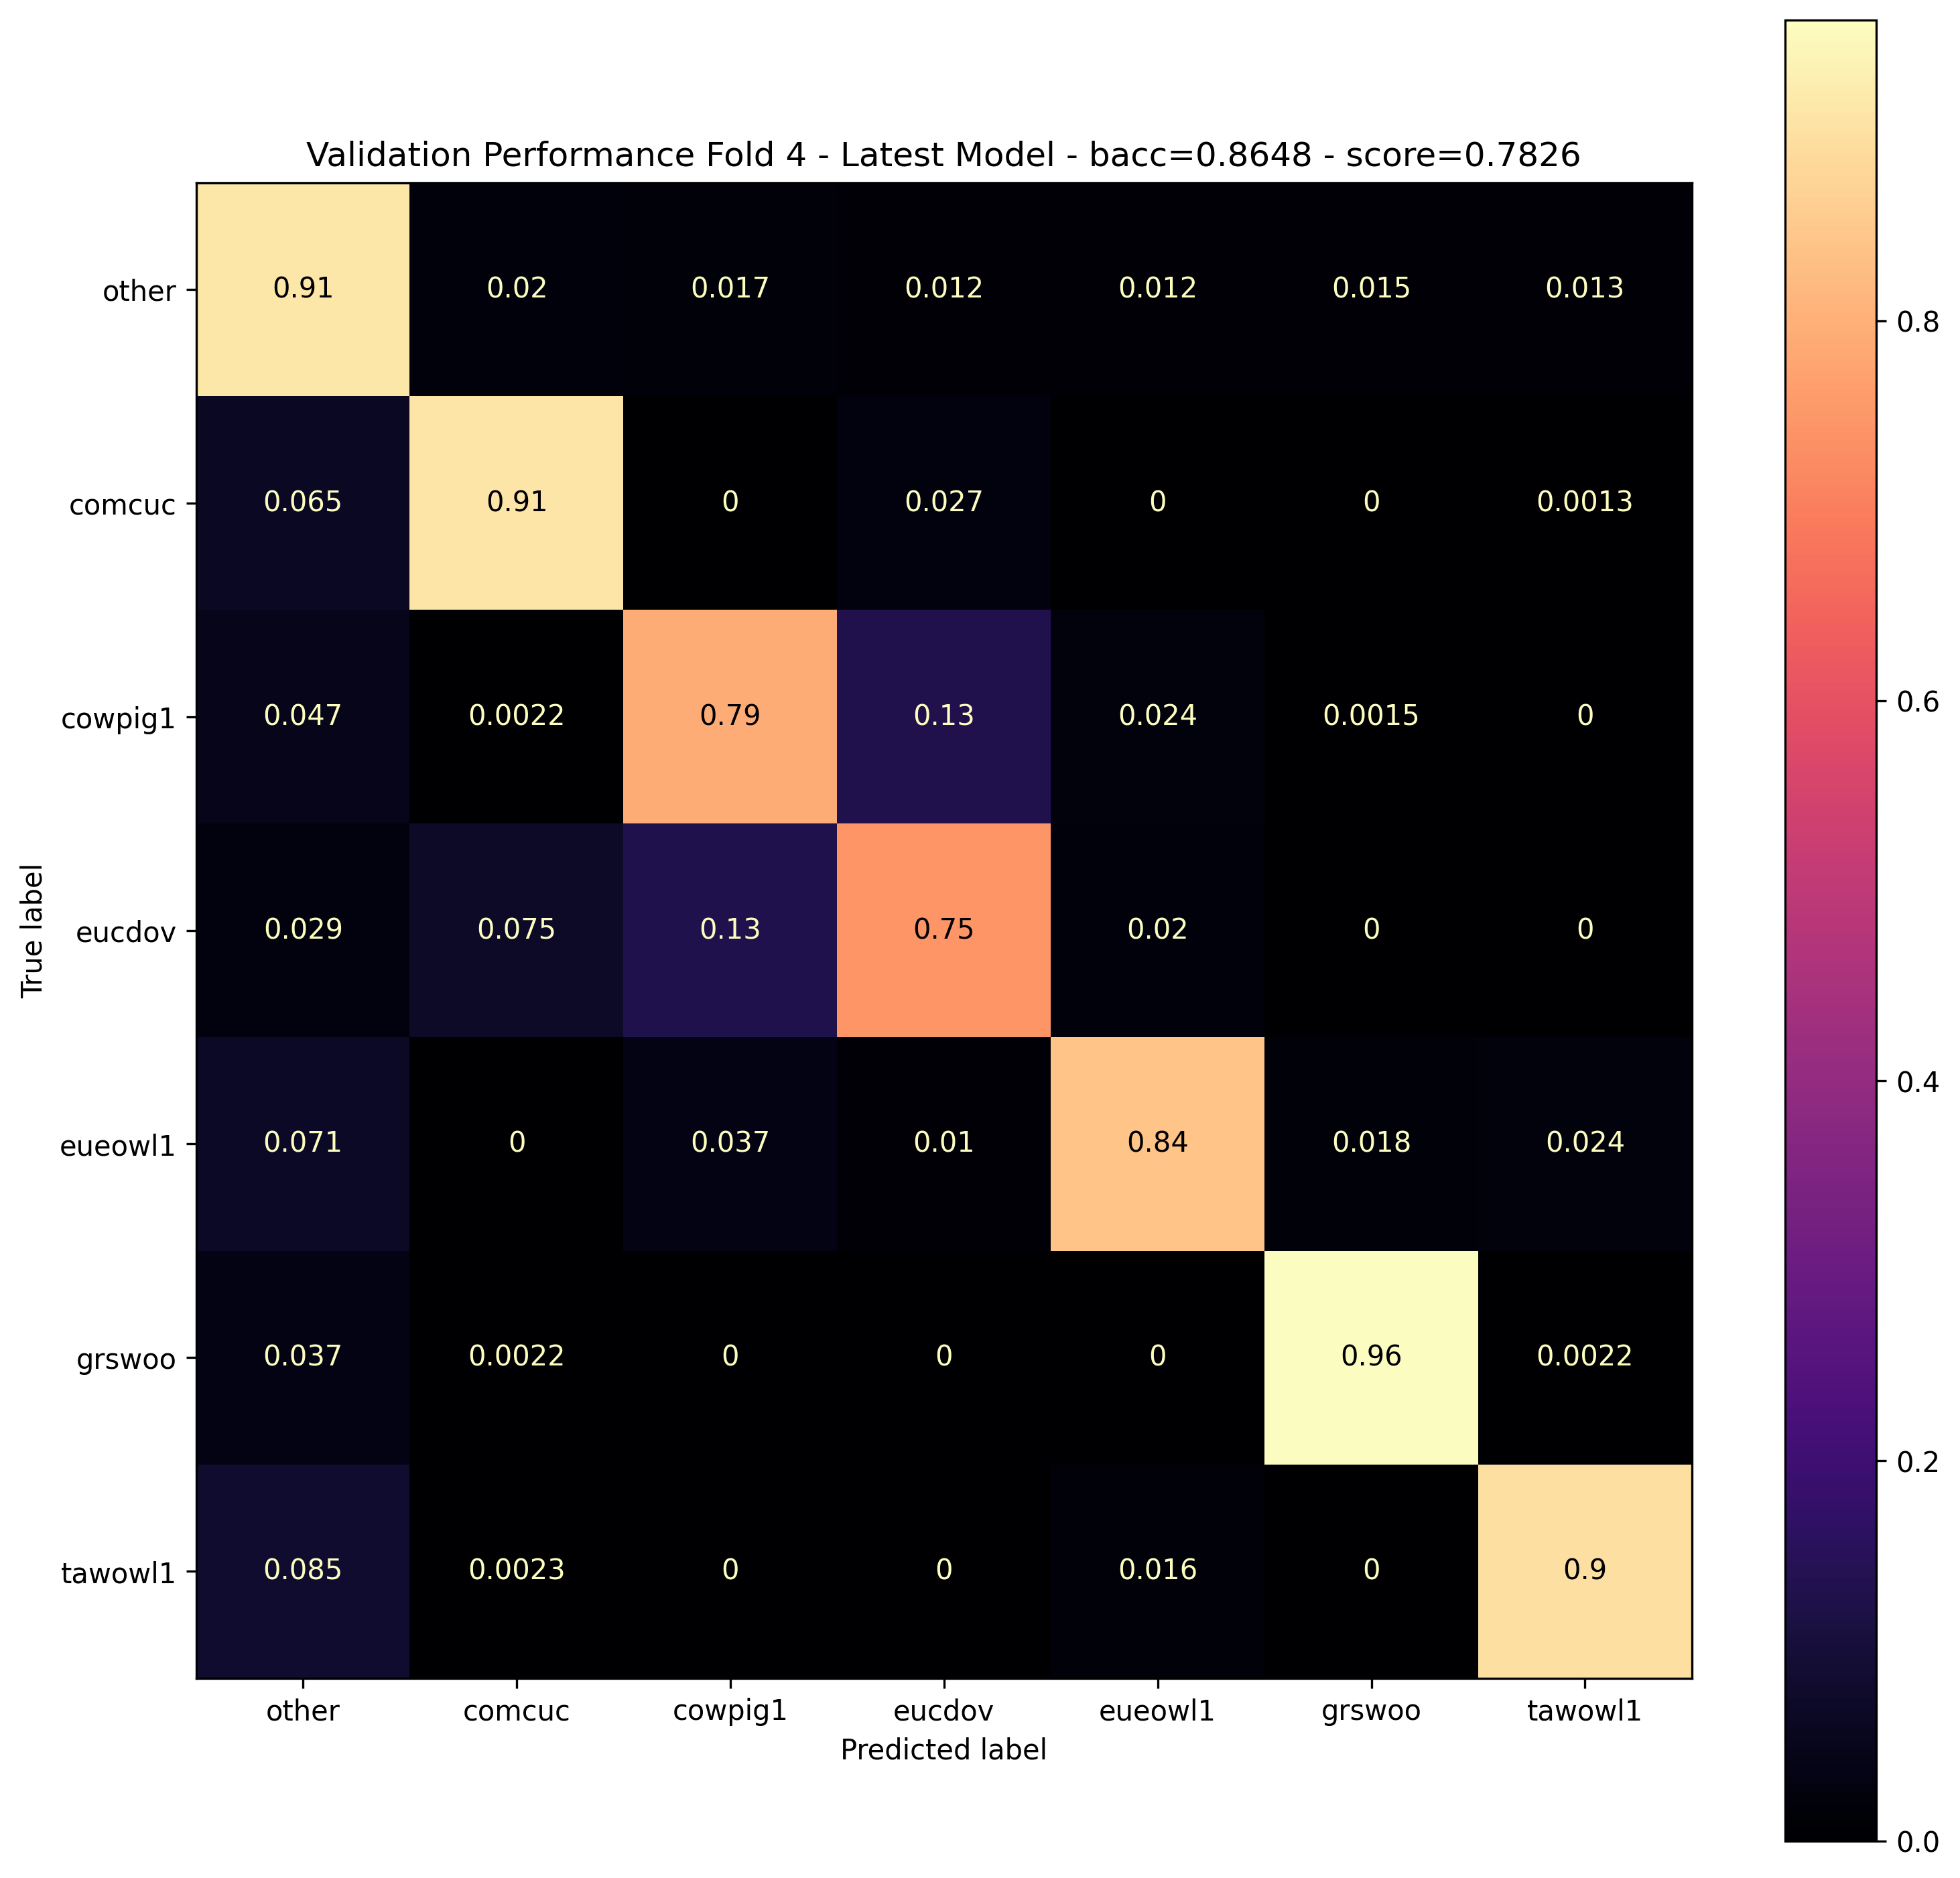

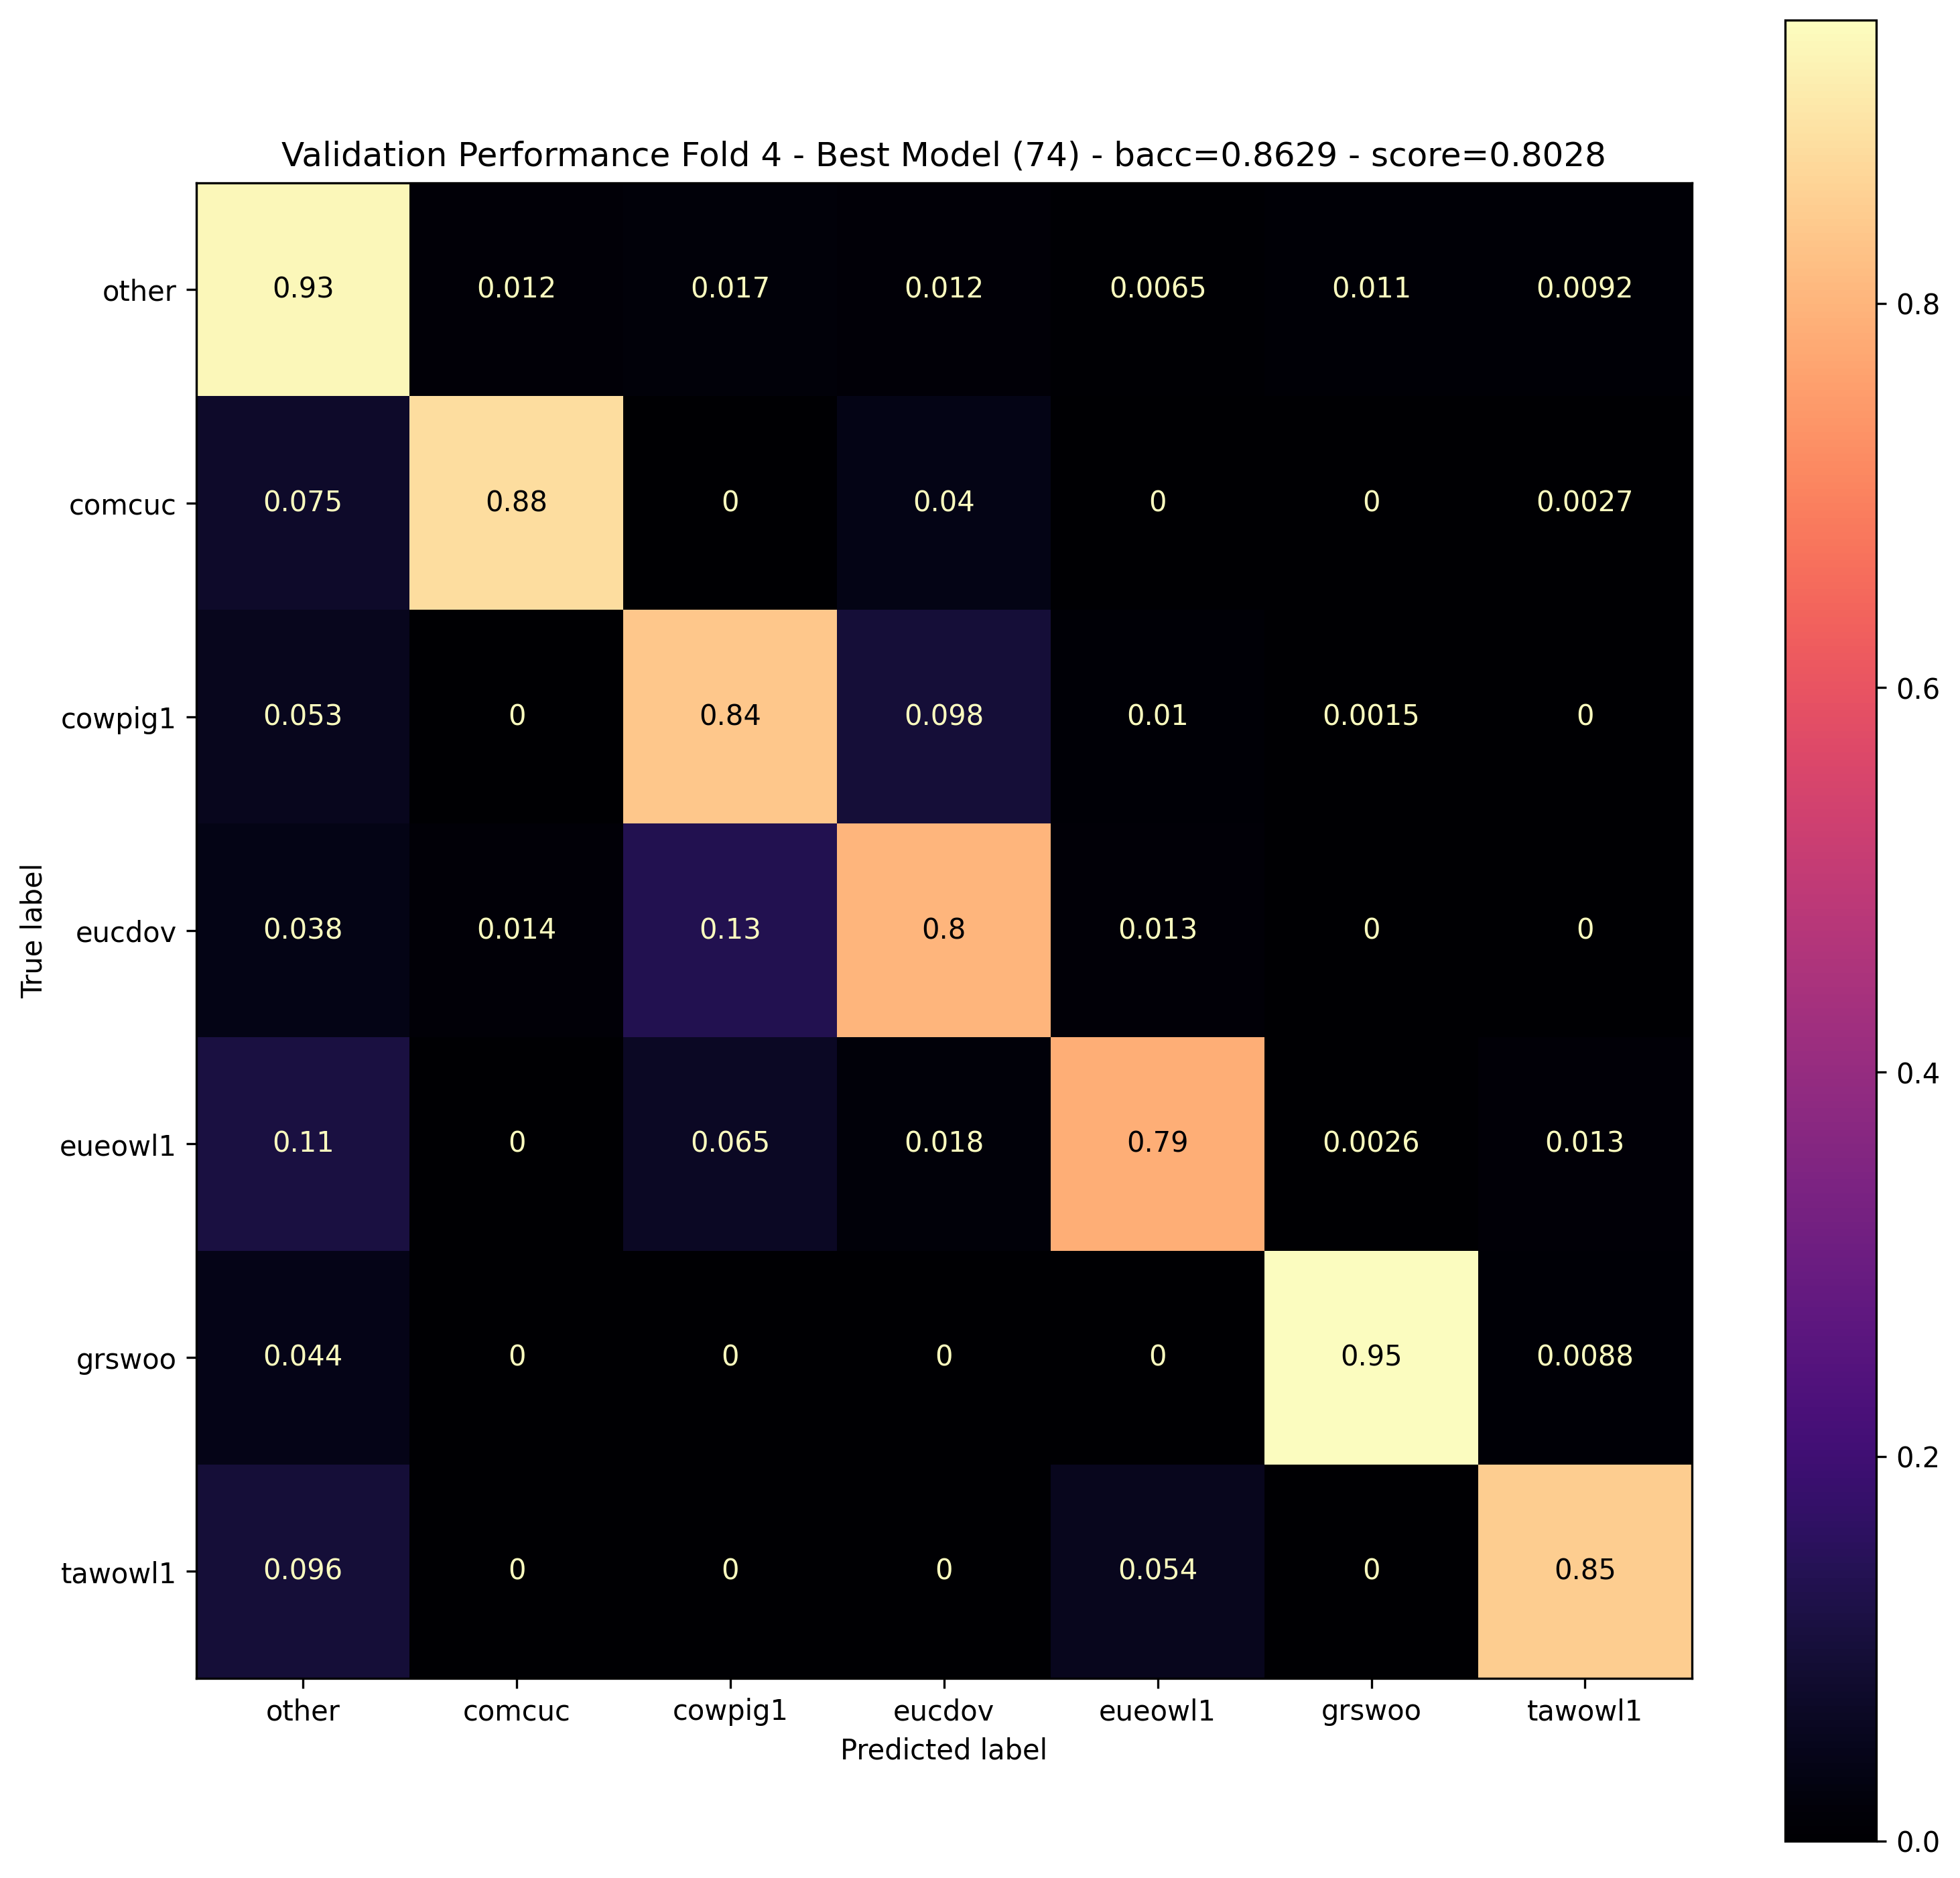

CV Folds:  62%|█████████████████████████████████████████████████▍                             | 5/8 [02:45<01:38, 32.84s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-4-best eval-score=0.8028"



Executing CV for fold 5
Training fold 5


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74784,  4905,  7556,  7357,  2076,  4417,  3905]
eval label counts  = [10574,   928,  1398,   841,   248,   694,   317]

balancing loss weights                    = [ 1.00, 15.25,  9.90, 10.17, 36.02, 16.93, 19.15]
balancing eval loss weights (theoretical) = [ 1.00, 11.39,  7.56, 12.57, 42.64, 15.24, 33.36]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000012, num_samples = 105000, num_correct = 36226, acc = 0.345010, bacc = 0.191466, score = -0.174952
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000438, num_samples

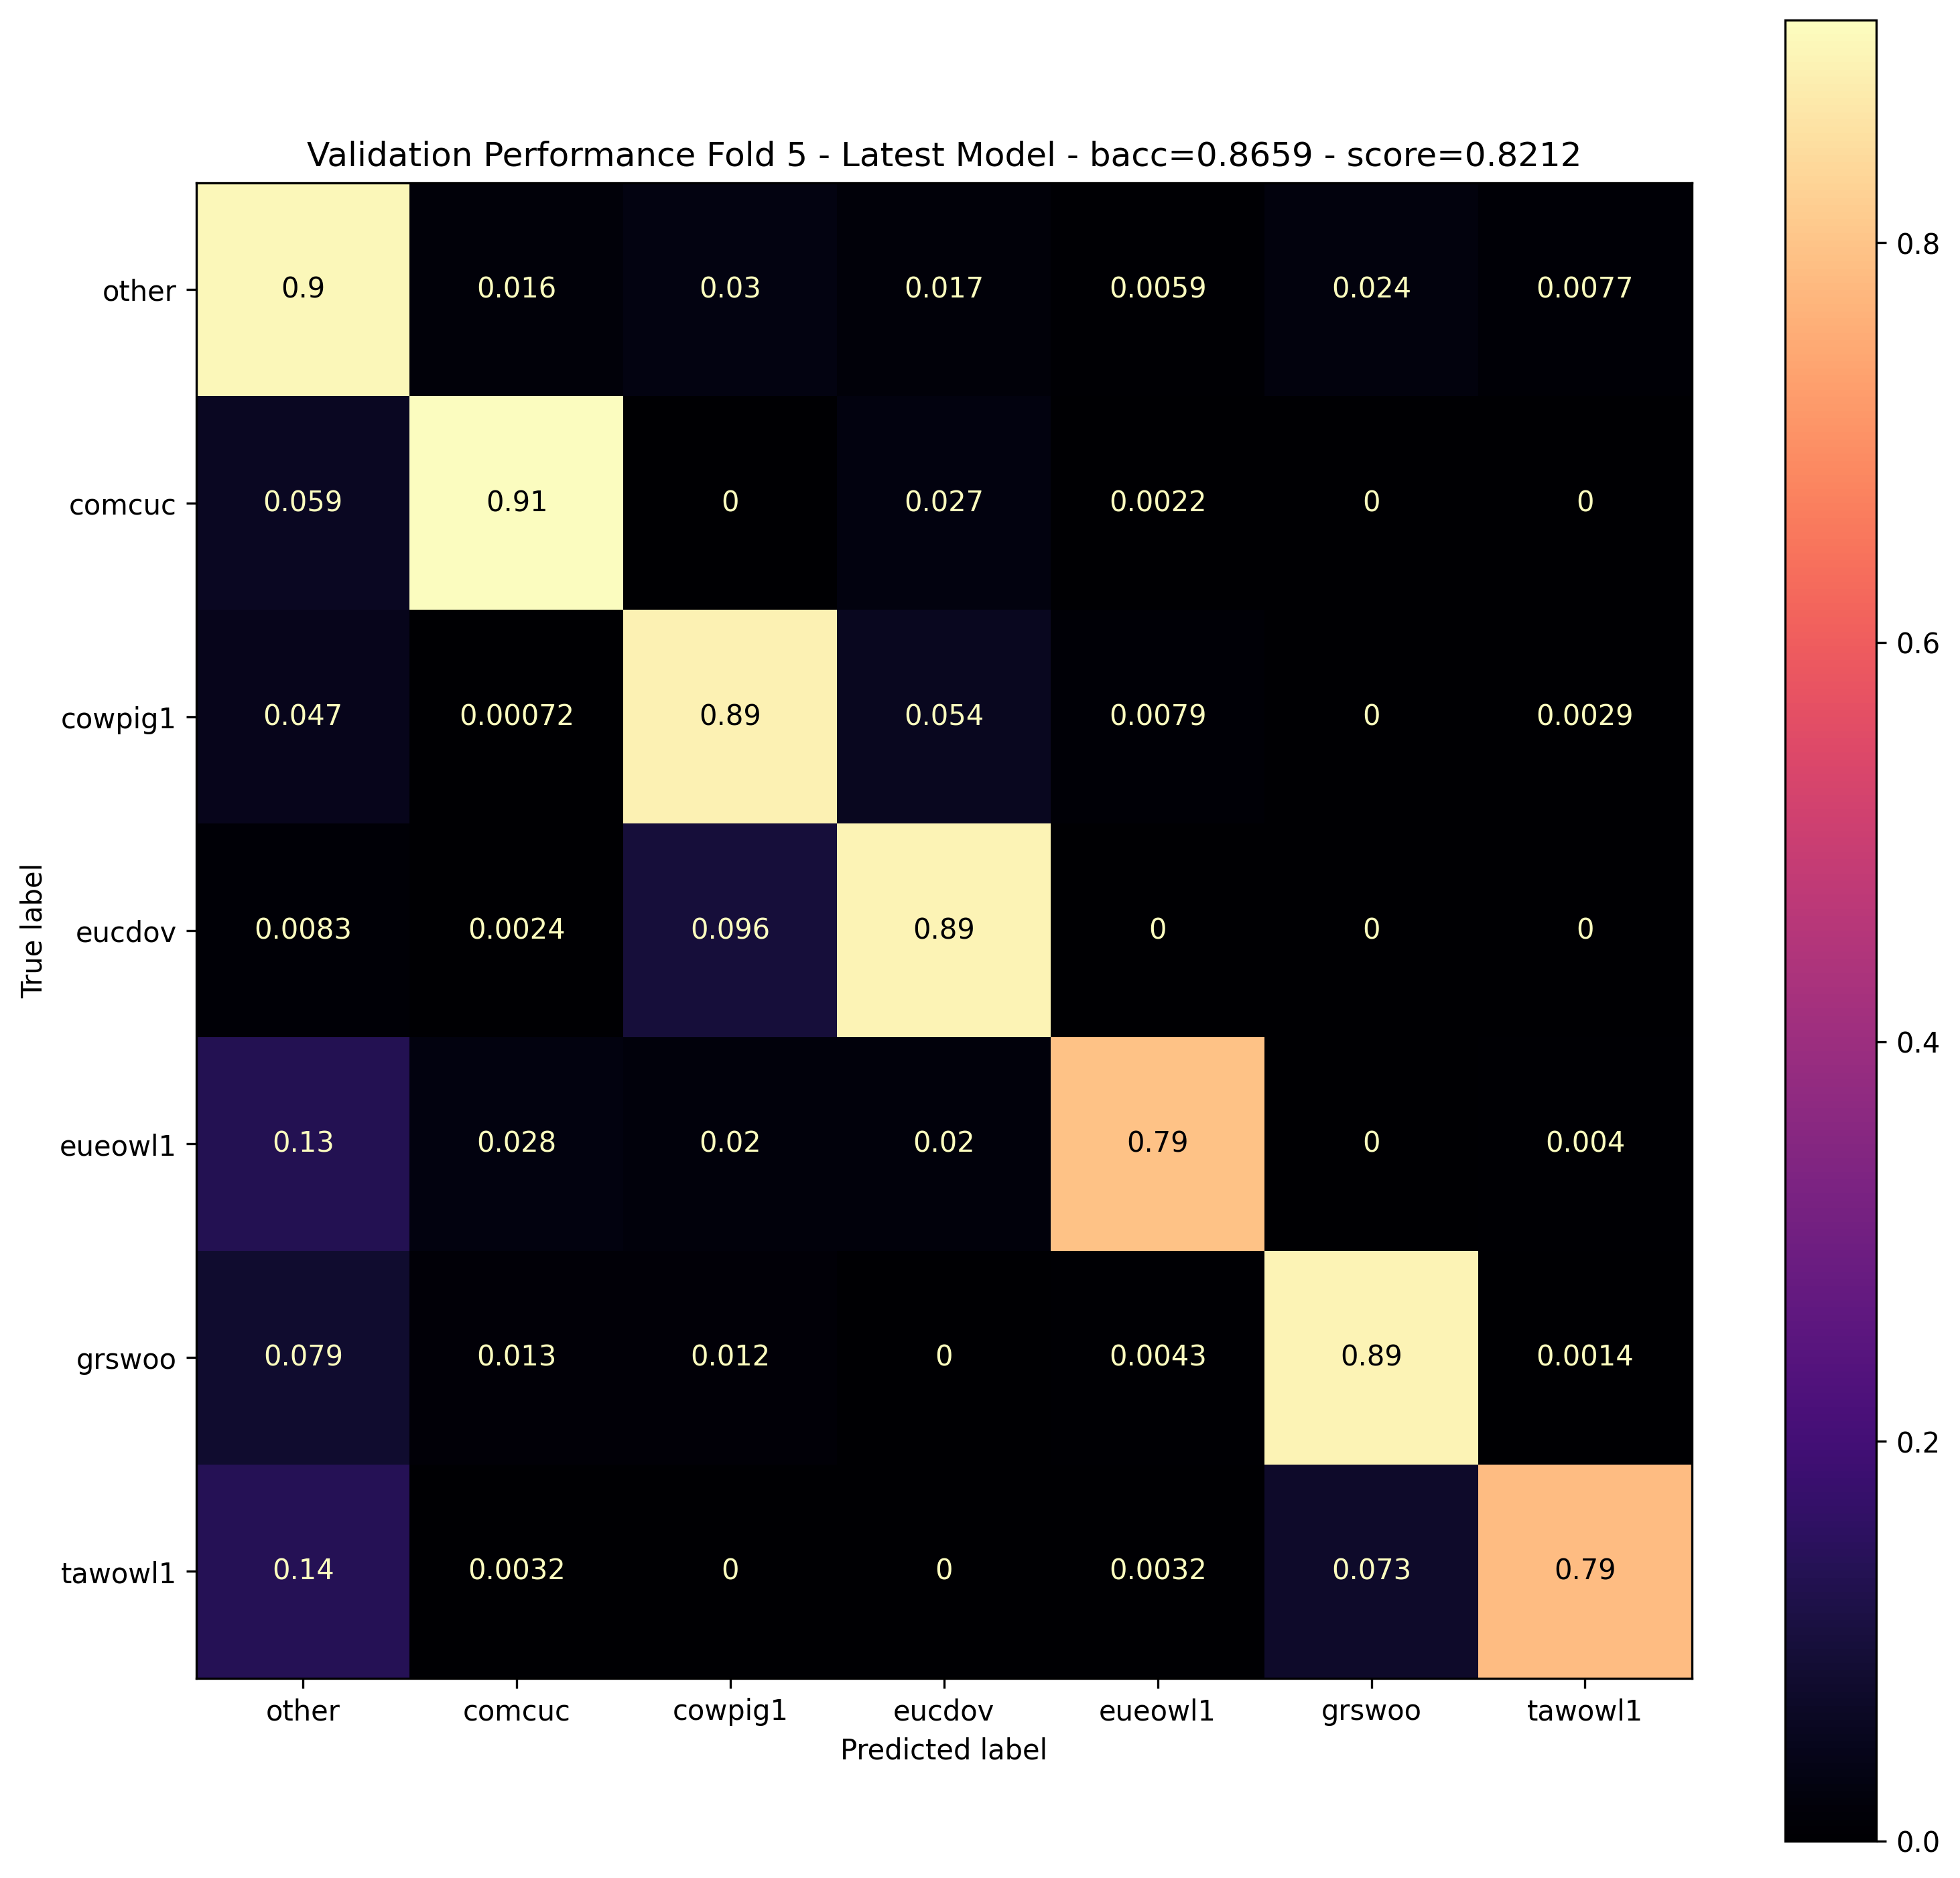

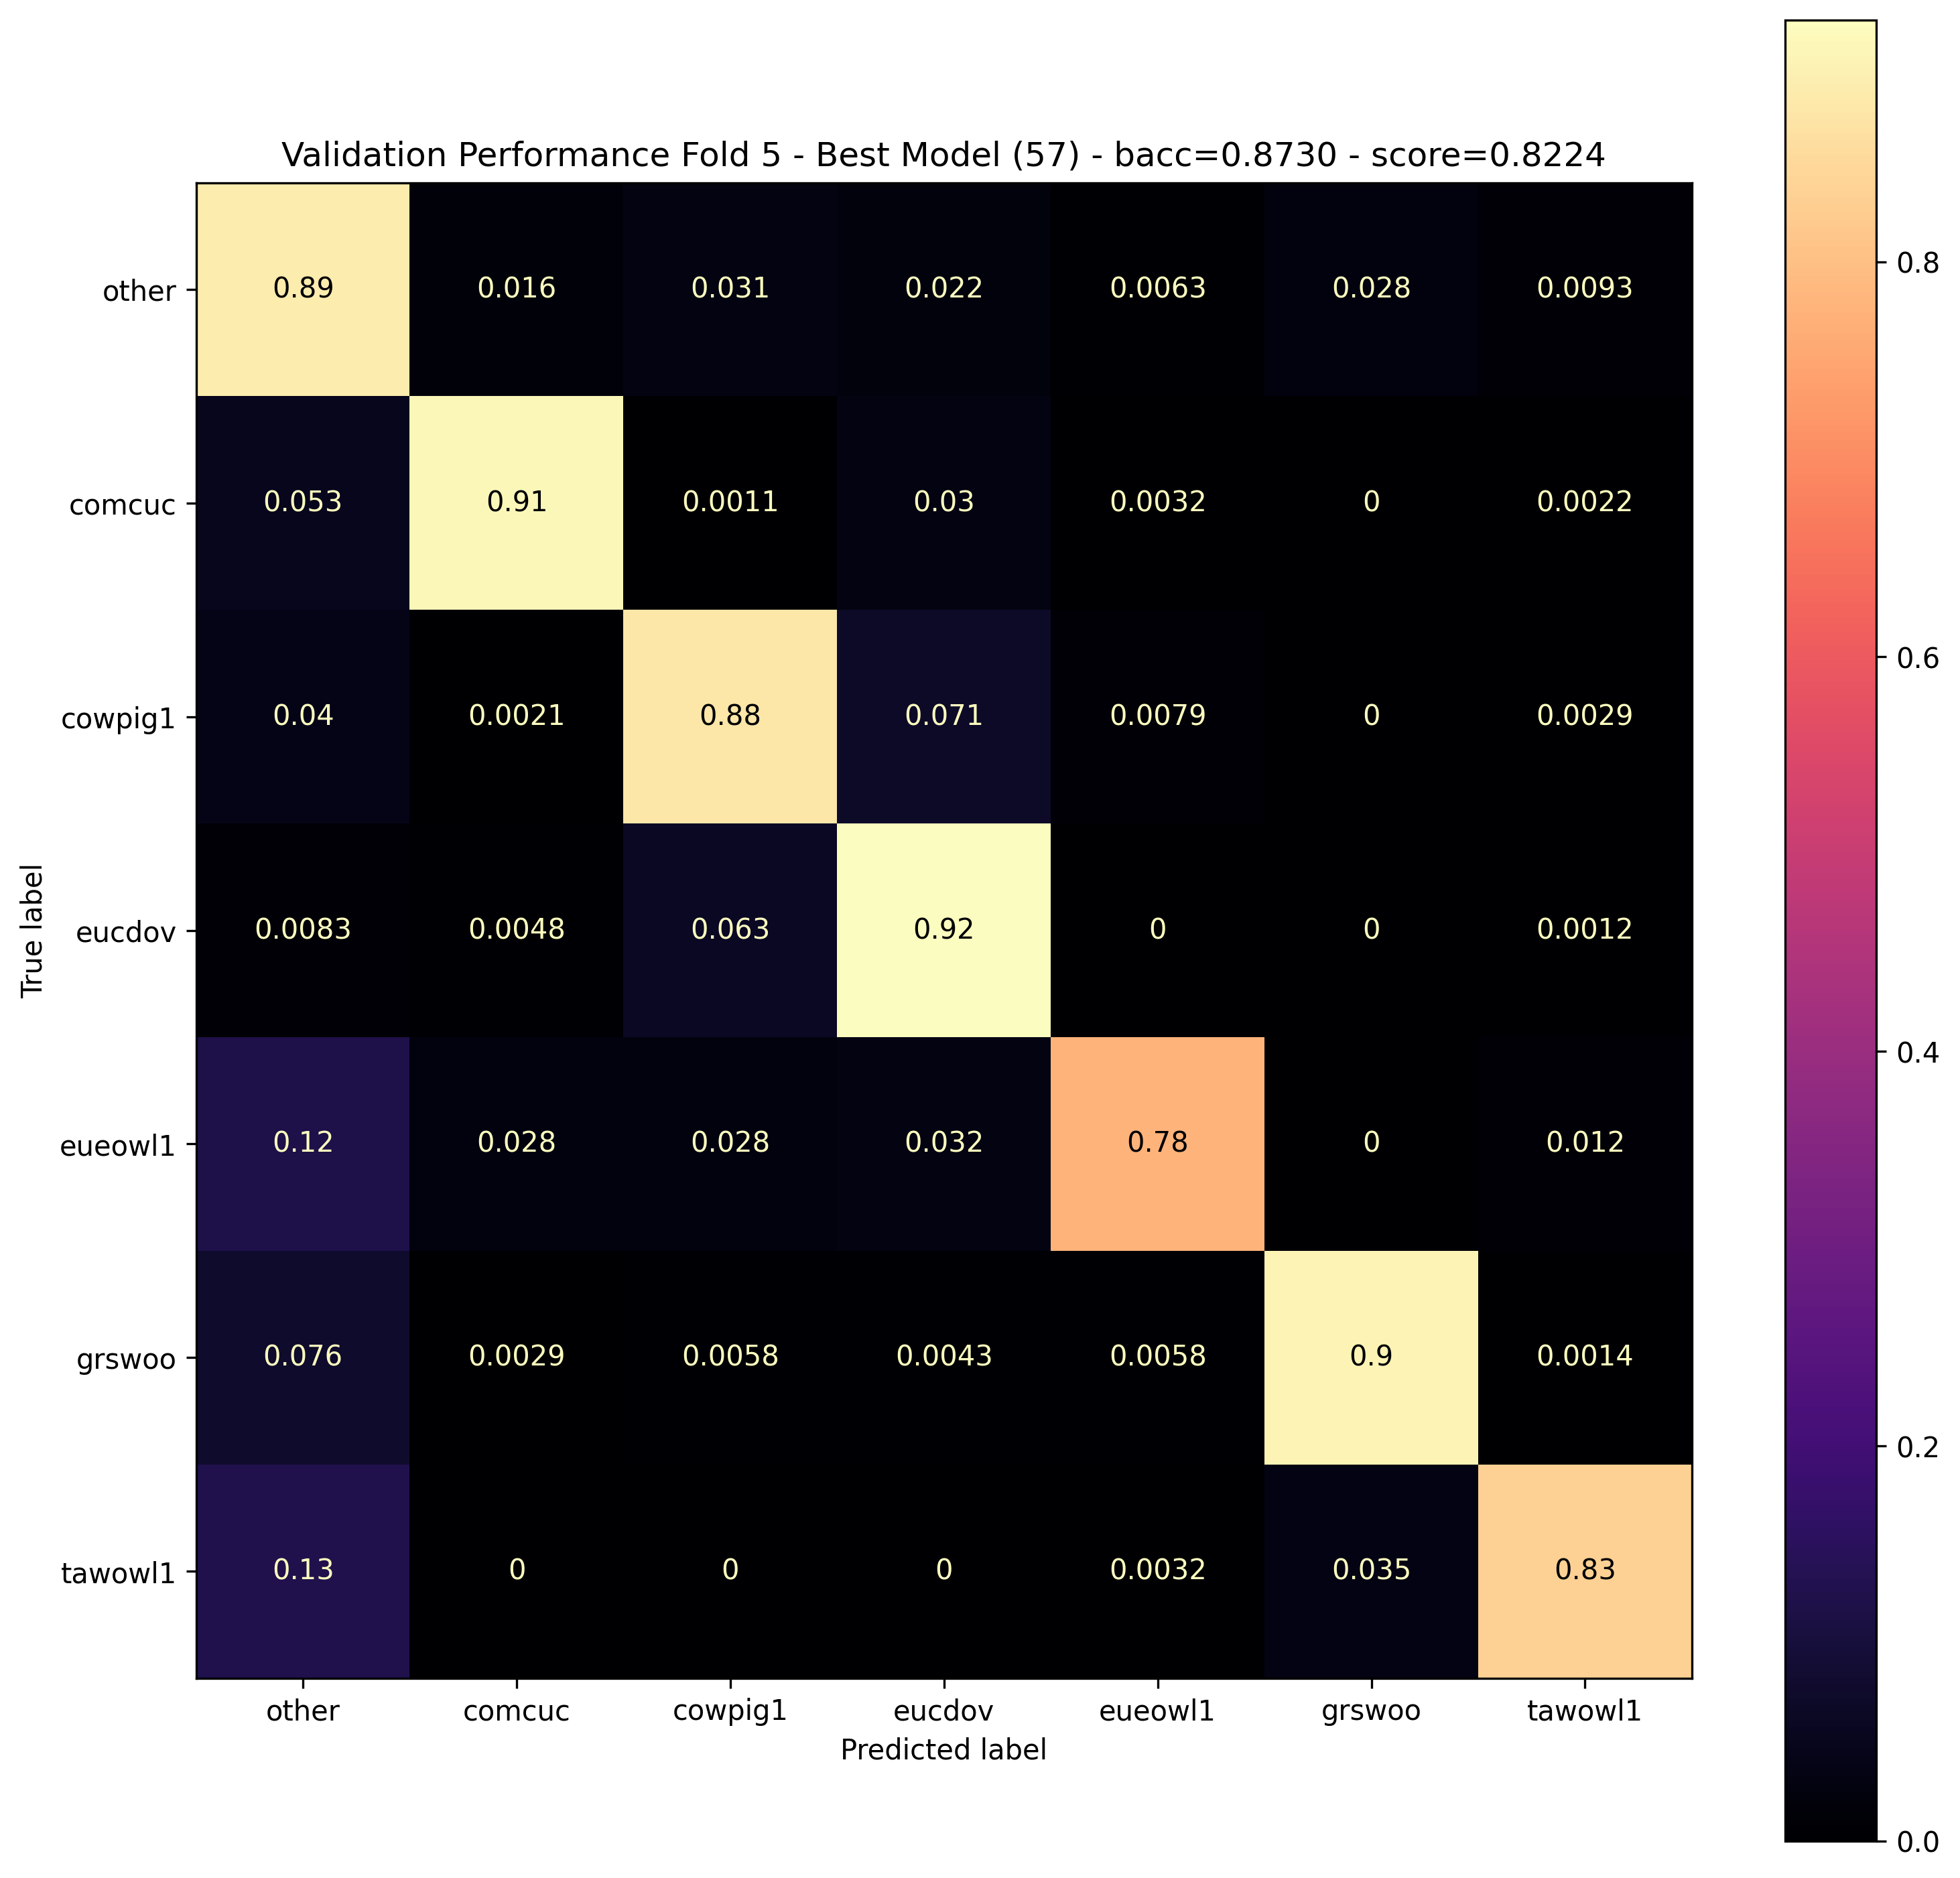

CV Folds:  75%|███████████████████████████████████████████████████████████▎                   | 6/8 [03:22<01:08, 34.12s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-5-best eval-score=0.8224"



Executing CV for fold 6
Training fold 6


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [75040,  5048,  7713,  7079,  2058,  4391,  3671]
eval label counts  = [10318,   785,  1241,  1119,   266,   720,   551]

balancing loss weights                    = [ 1.00, 14.87,  9.73, 10.60, 36.46, 17.09, 20.44]
balancing eval loss weights (theoretical) = [ 1.00, 13.14,  8.31,  9.22, 38.79, 14.33, 18.73]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000012, num_samples = 105000, num_correct = 35992, acc = 0.342781, bacc = 0.197958, score = -0.182343
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000187, num_samples

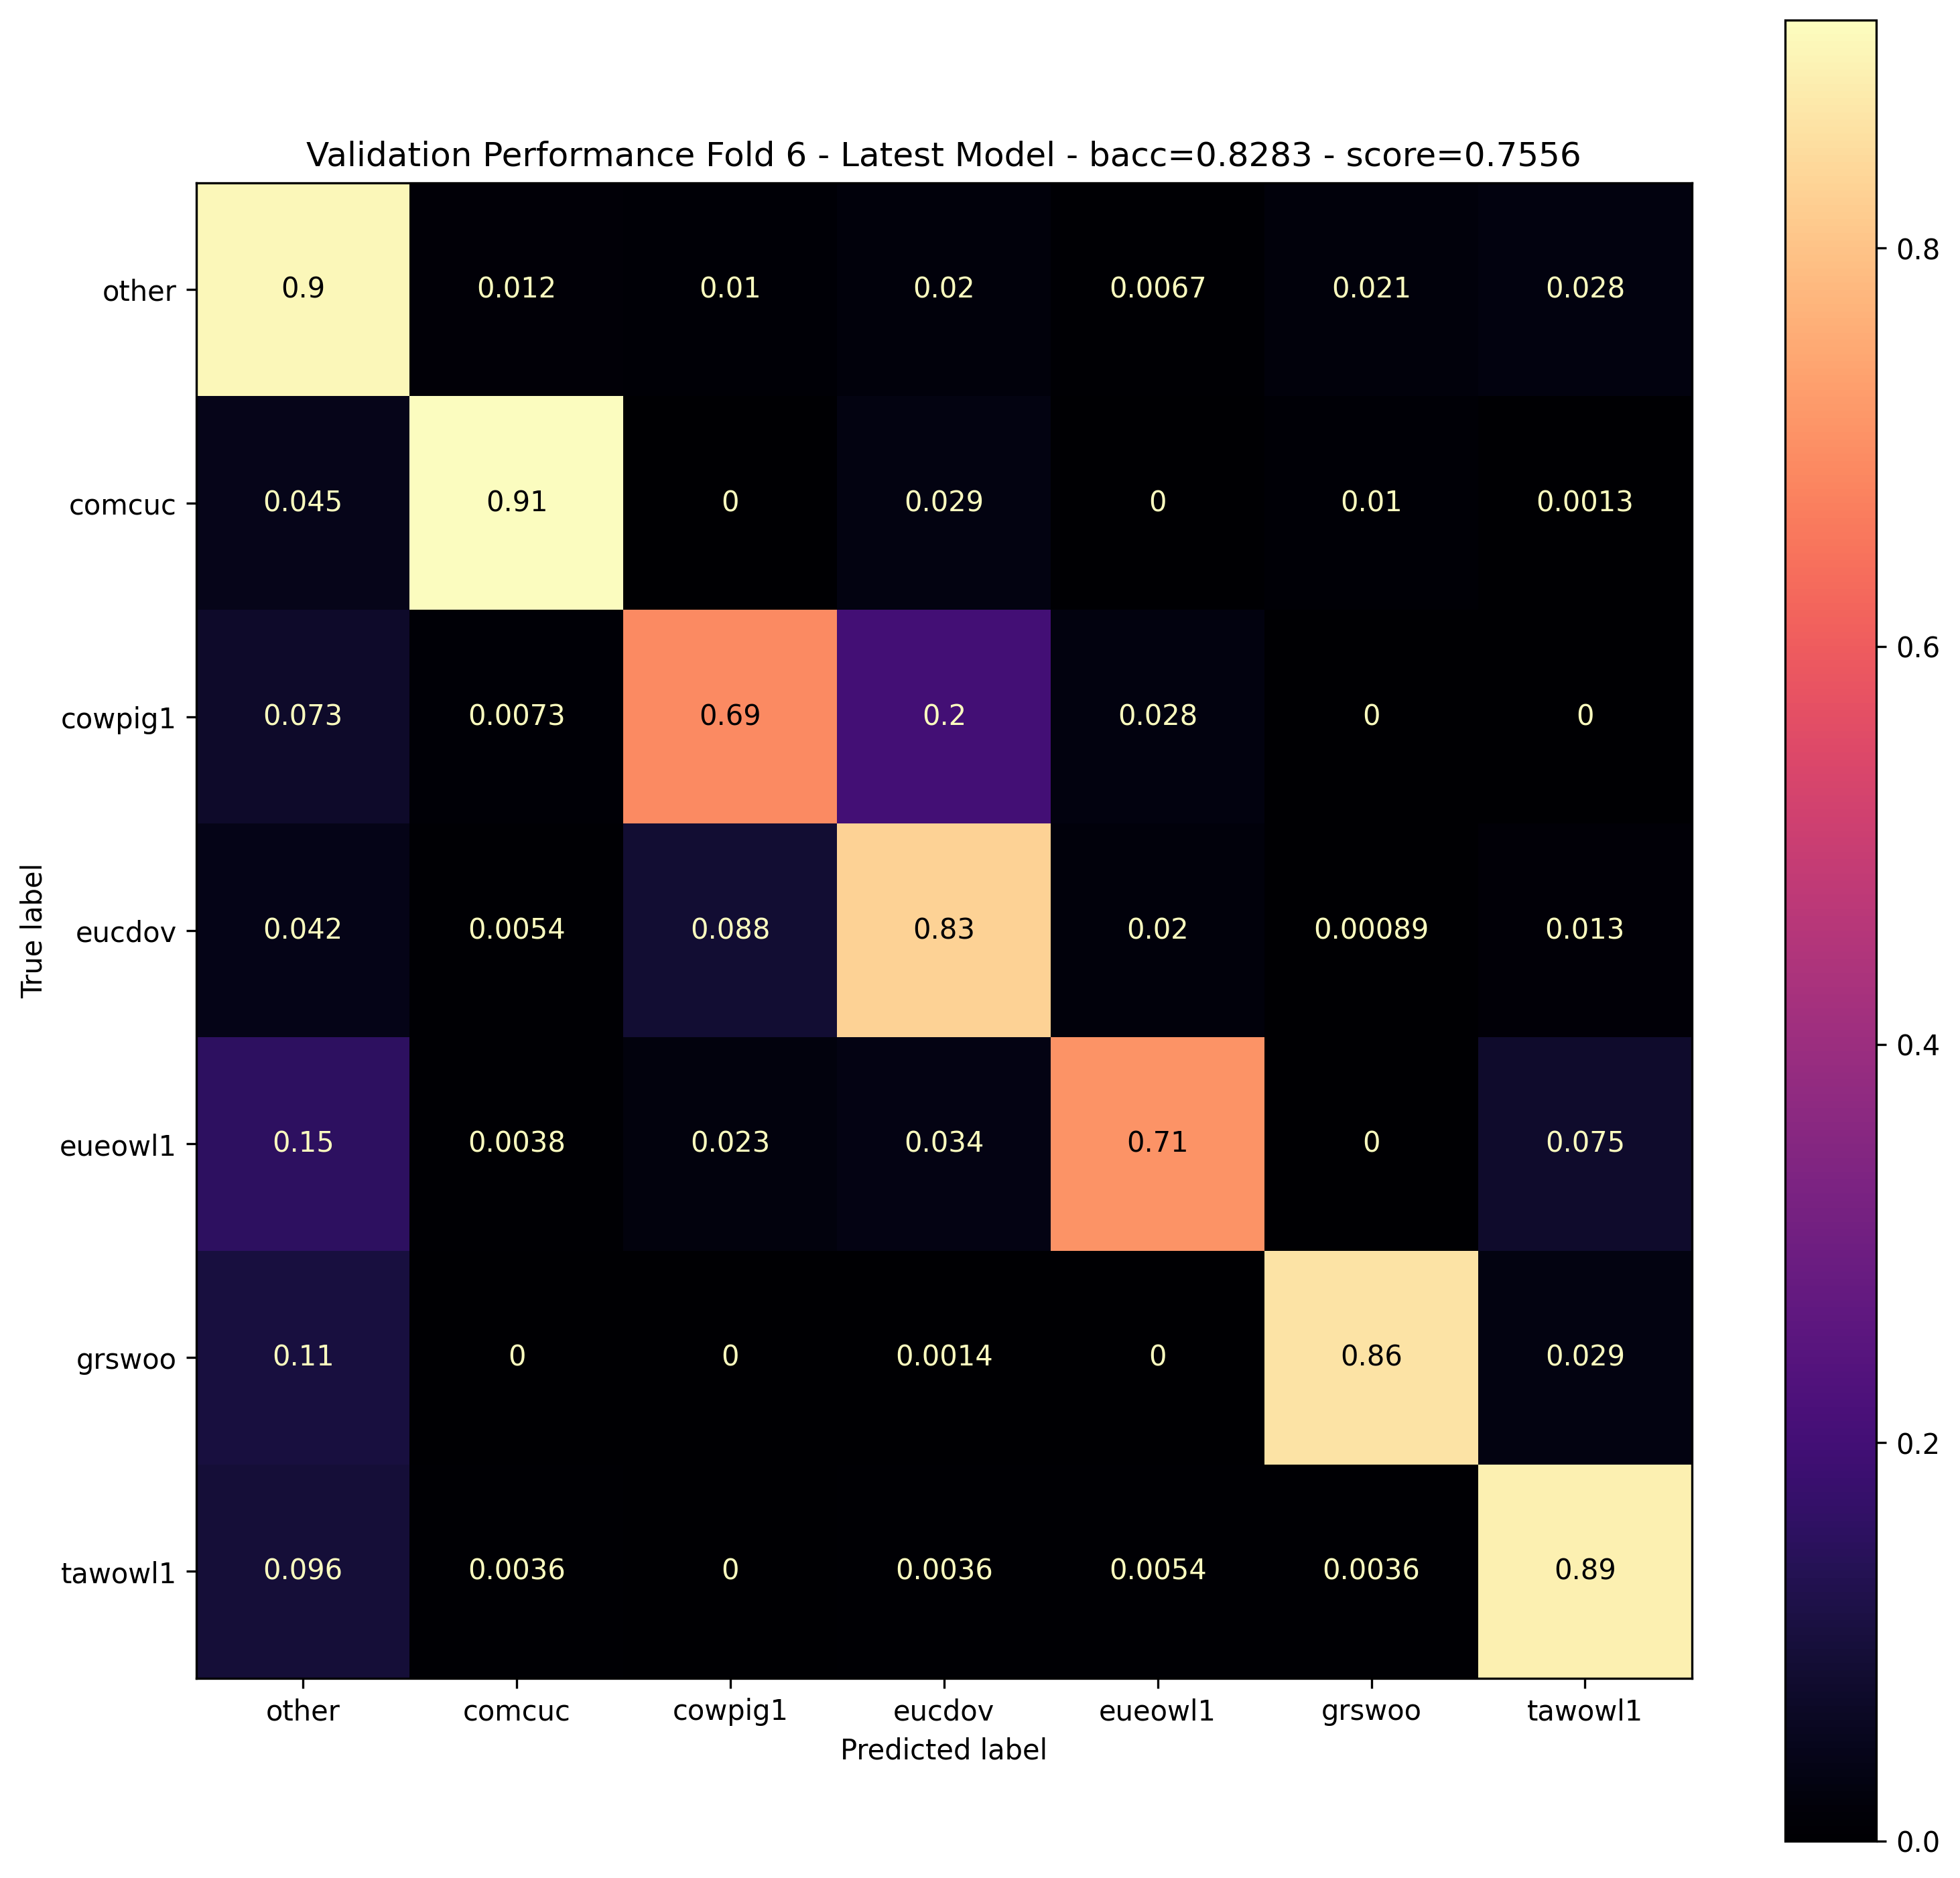

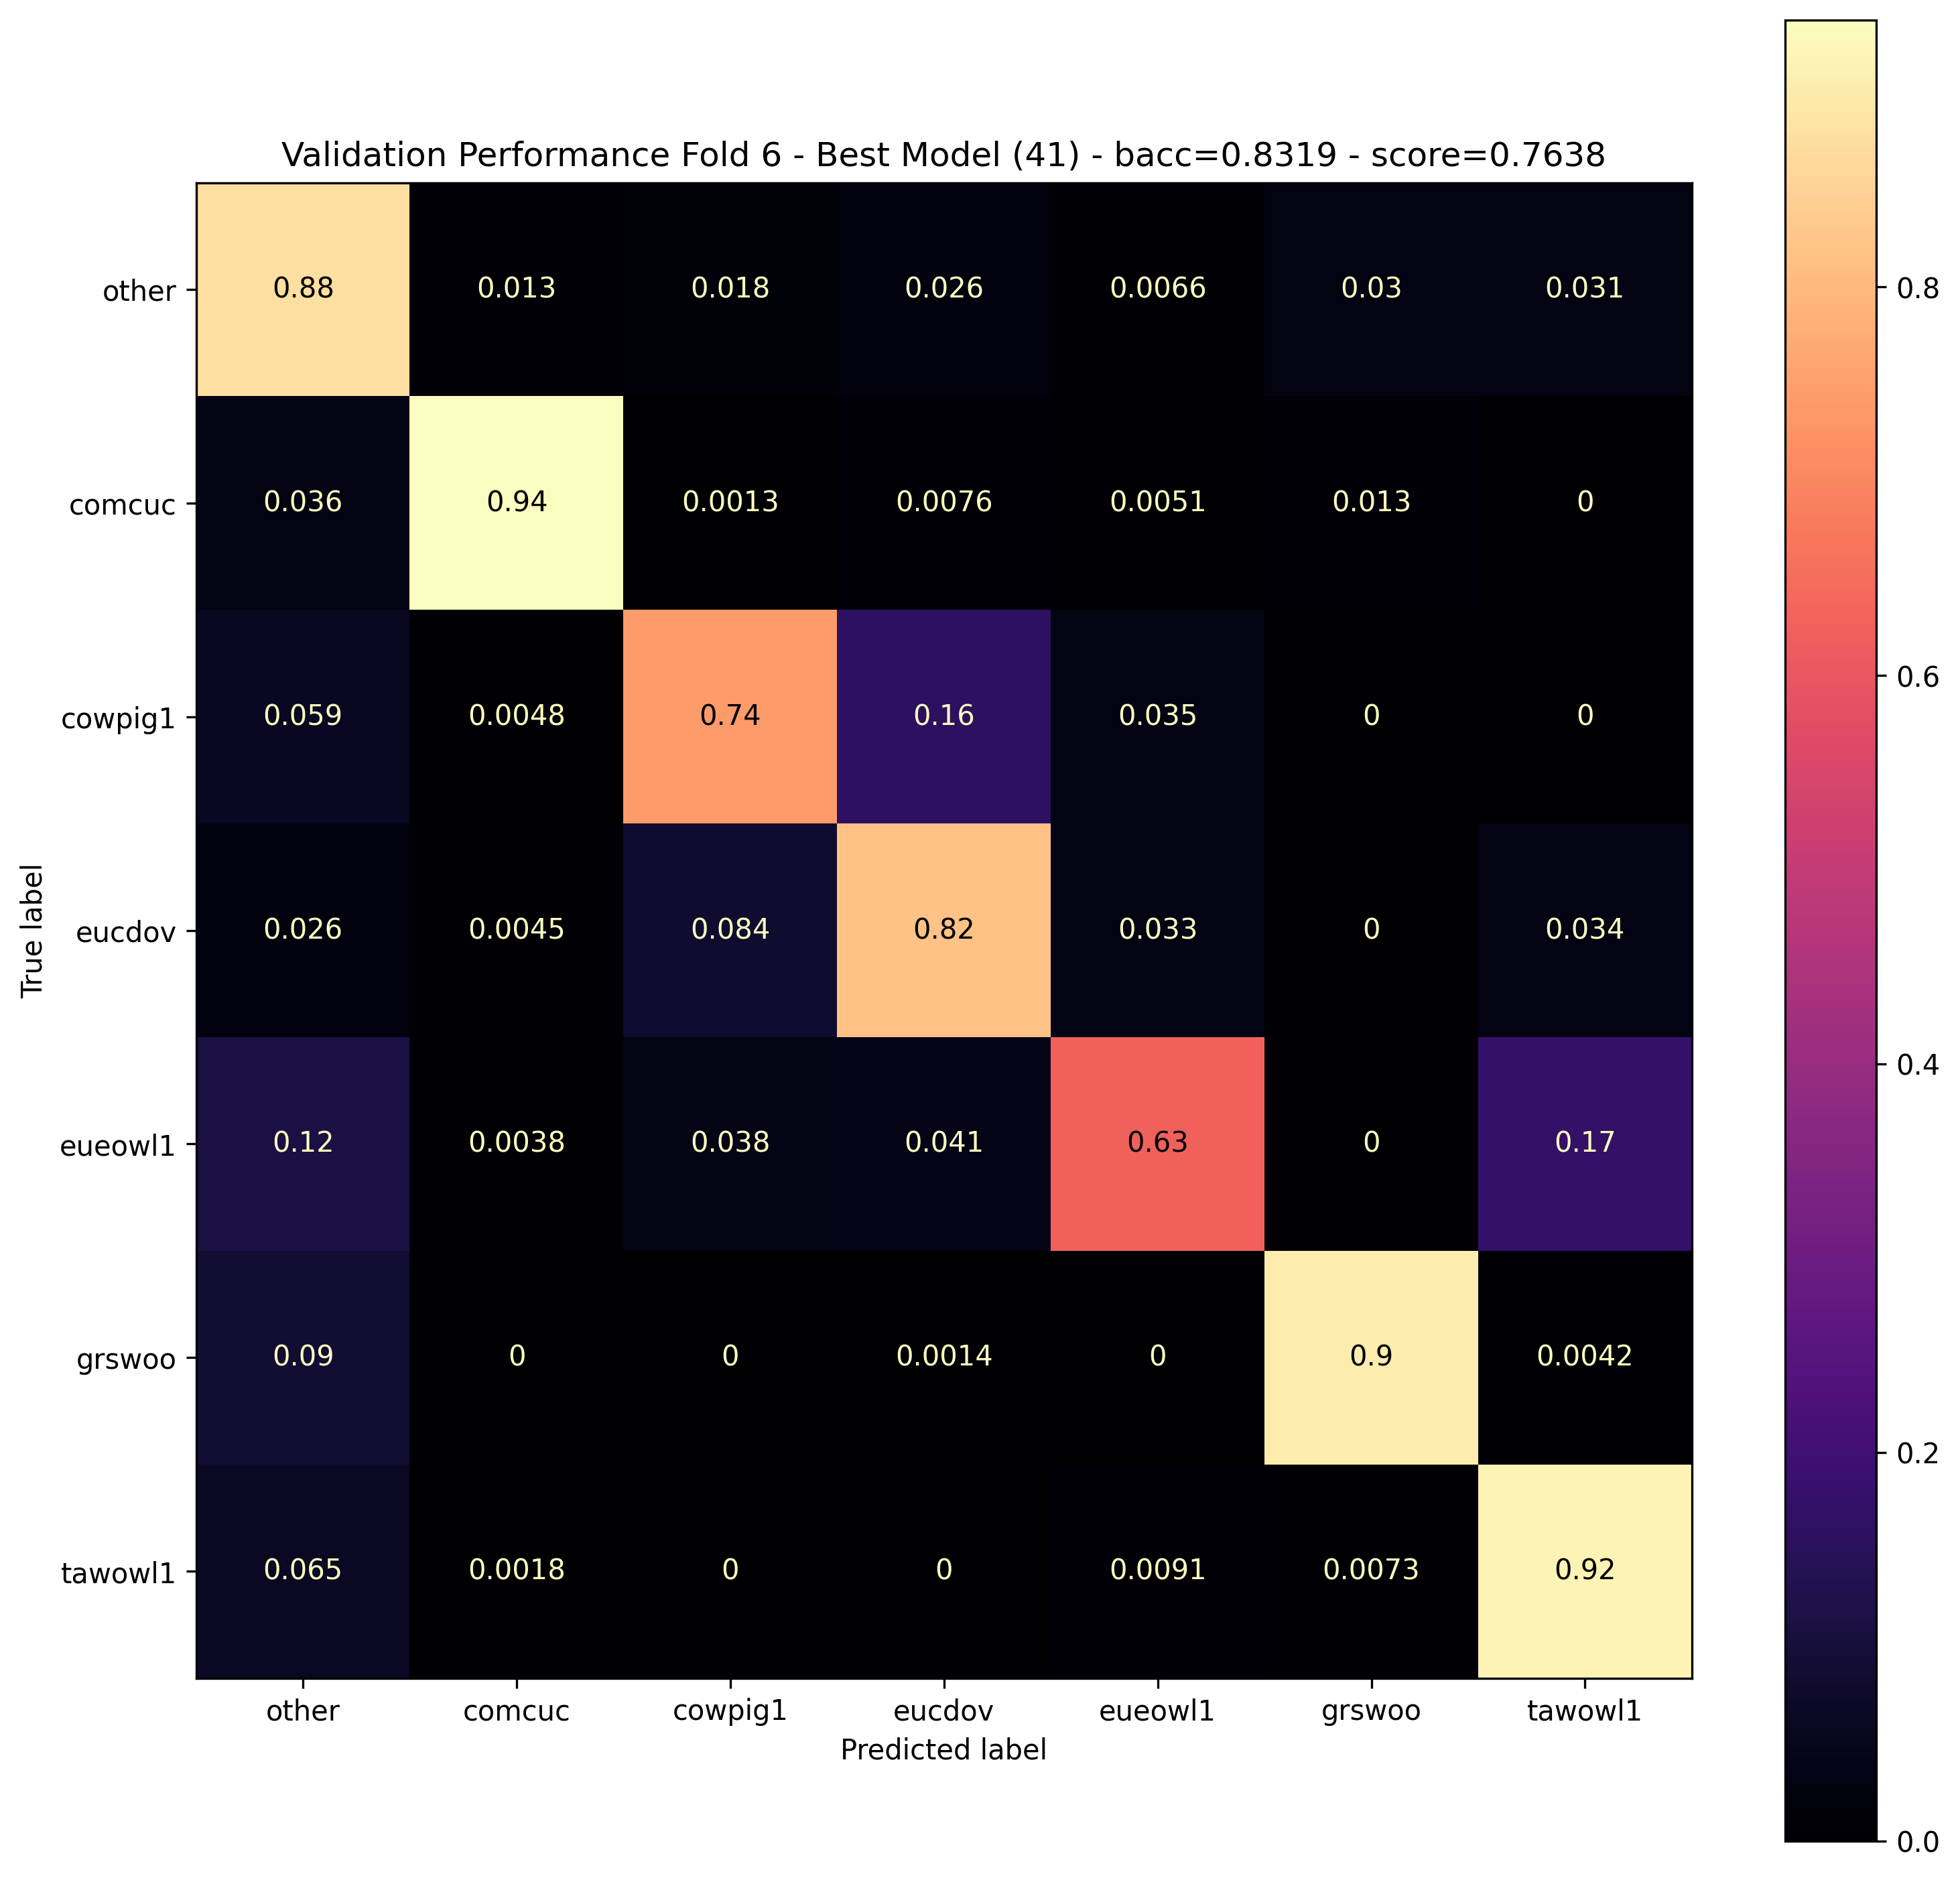

CV Folds:  88%|█████████████████████████████████████████████████████████████████████▏         | 7/8 [03:55<00:34, 34.05s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-6-best eval-score=0.7638"



Executing CV for fold 7
Training fold 7


#### Training ####
##################
CNNClassifier with 62313 parameters: 
in_fnn:                28704, 
conv1d_embedding:       2624, 
conv2d_embedding:       4704, 
conv1d_layers:         11456, 
conv2d_layers:         10434, 
out_fnn:                4231, 

##################

train label counts = [74339,  5363,  8559,  6948,  2097,  4259,  3435]
eval label counts  = [11019,   470,   395,  1250,   227,   852,   787]

balancing loss weights                    = [ 1.00, 13.86,  8.69, 10.70, 35.45, 17.45, 21.64]
balancing eval loss weights (theoretical) = [ 1.00, 23.44, 27.90,  8.82, 48.54, 12.93, 14.00]


Training Epoch   1/80 : lr = 1.00E-02, epoch =     1, avg_loss = 0.000013, num_samples = 105000, num_correct = 18530, acc = 0.176476, bacc = 0.164482, score = -0.281459
Evaluation Epoch   1/80 : epoch =     1, avg_loss = 0.000121, num_samples

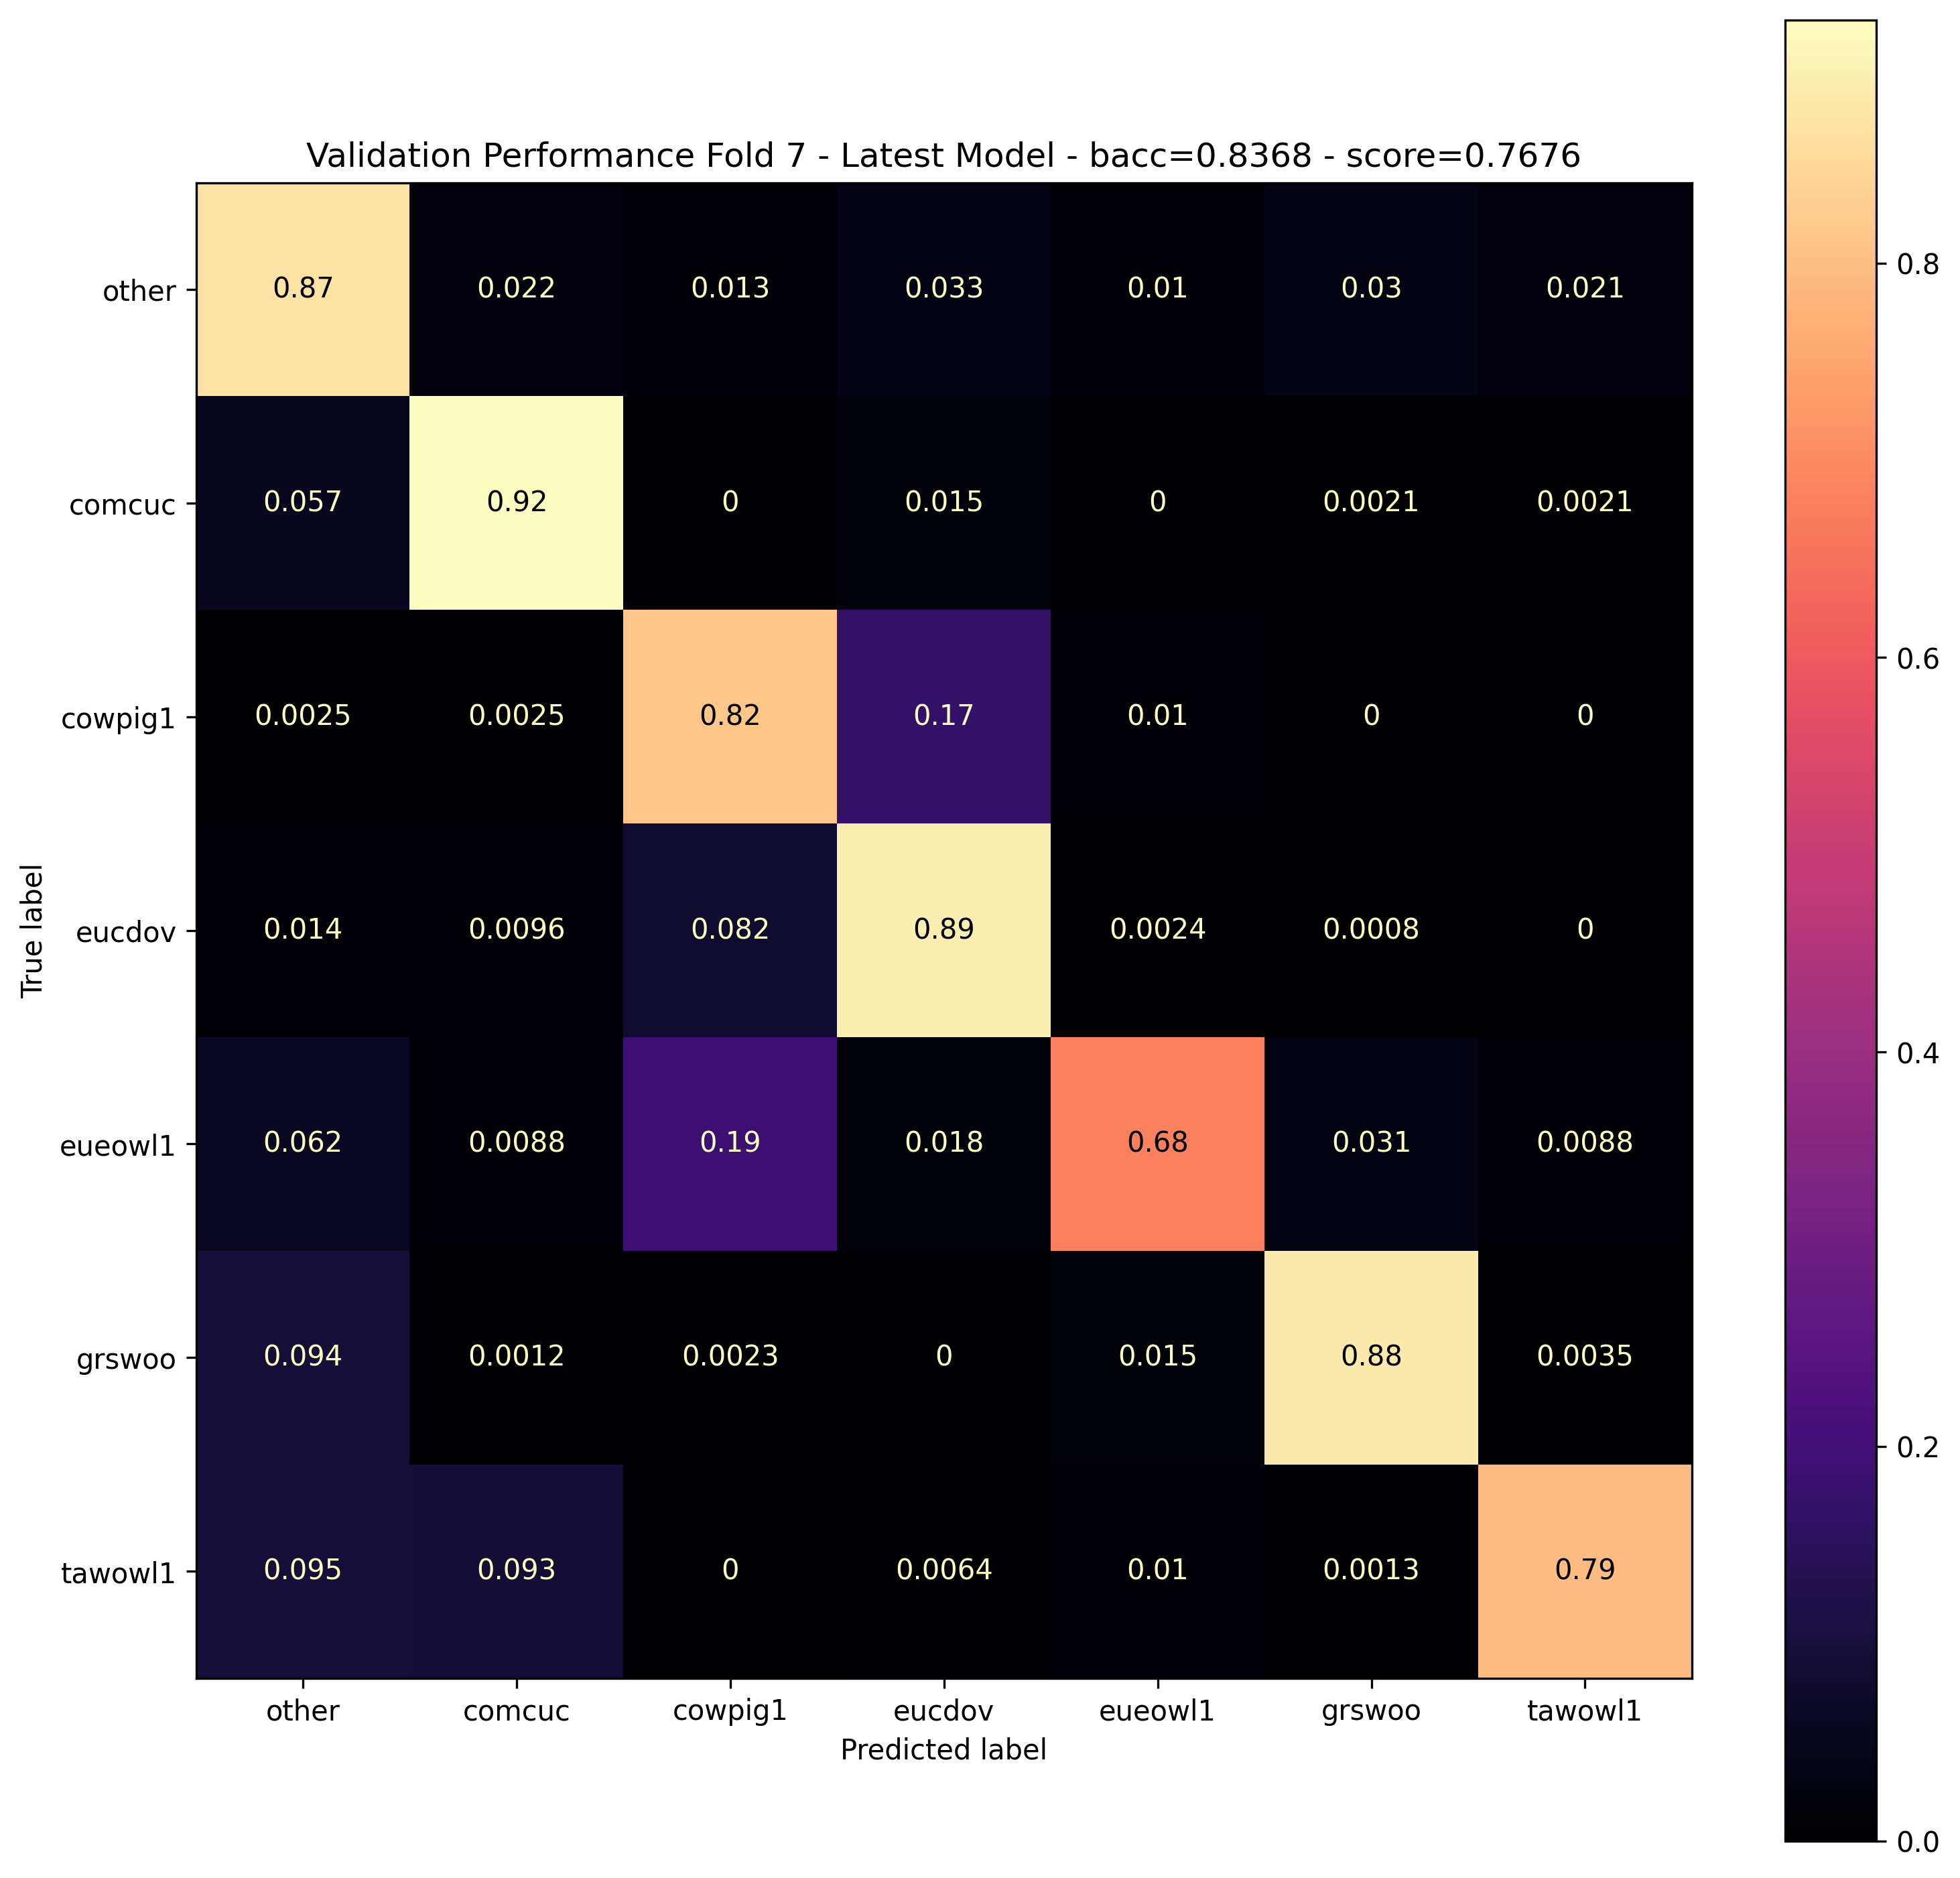

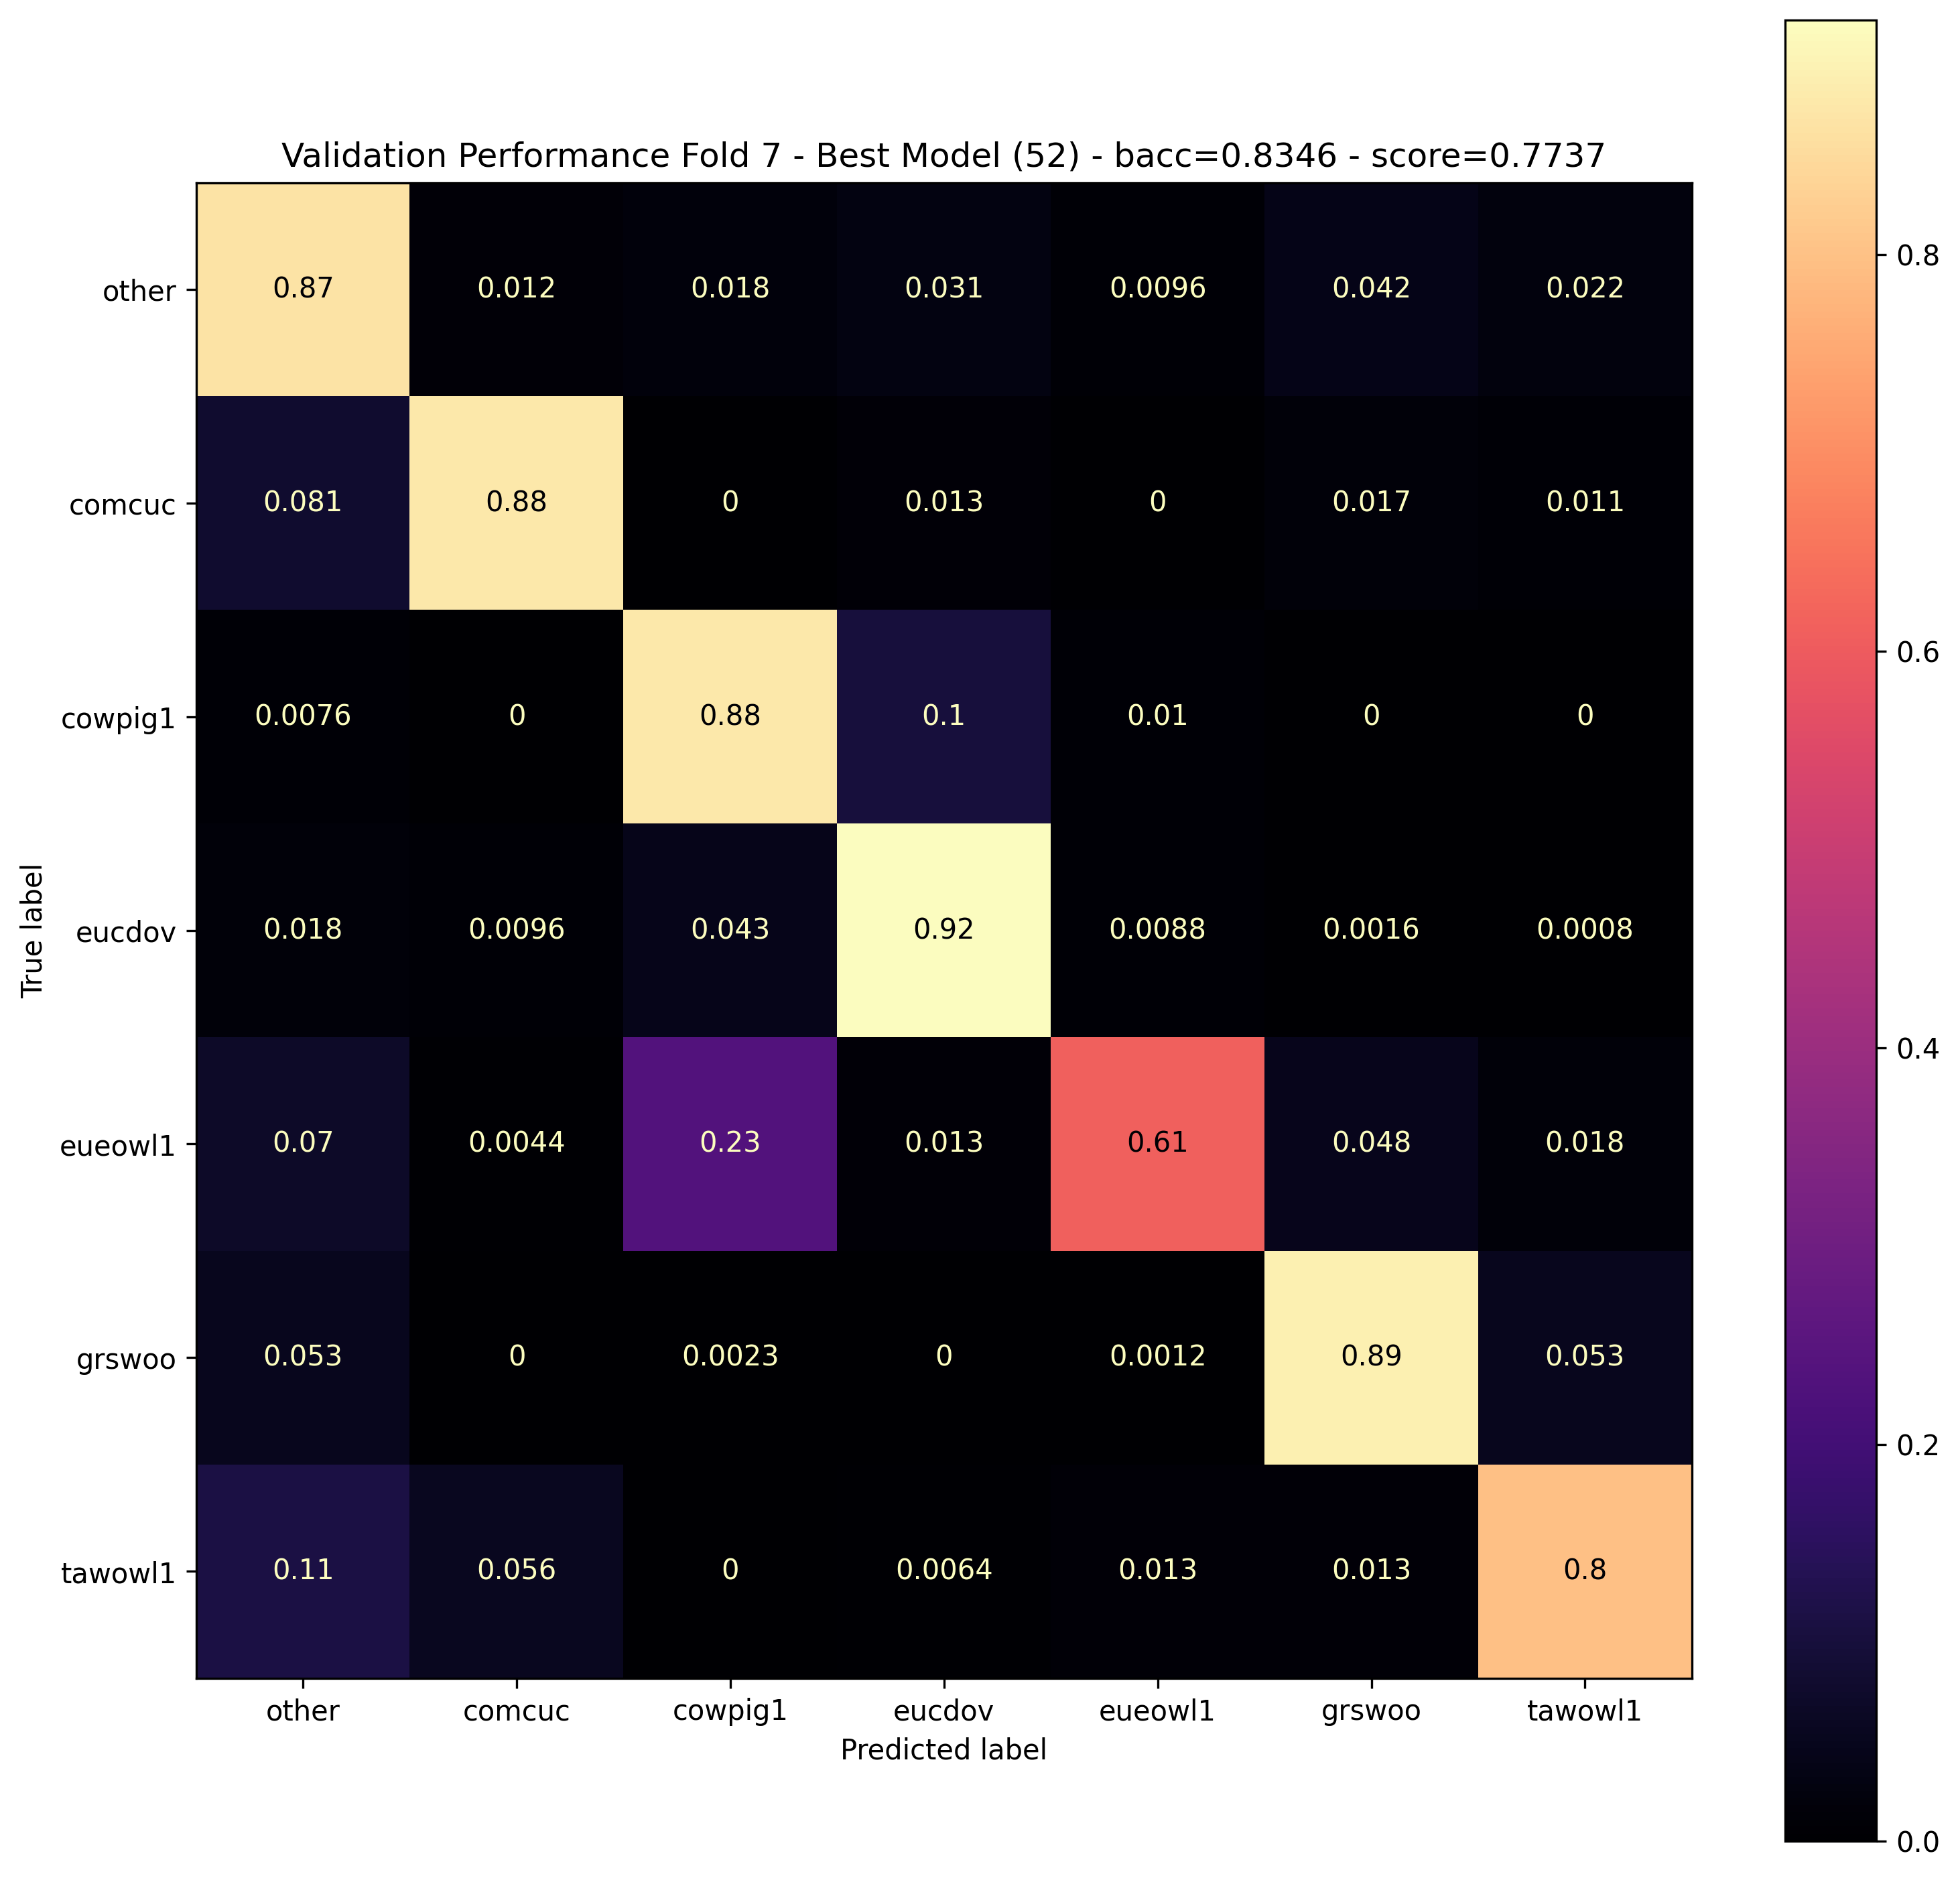

CV Folds: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [04:29<00:00, 33.63s/it]

Saved model with scaler as "species_classifier cv2023-06-22_14.43 fold-7-best eval-score=0.7737"


#################
#### Metrics ####
#################


cv_average_best_best_models_eval_metrics = epoch = 59.375000, avg_loss = 0.000978, num_samples = 15000.000000, num_correct = 13185.500000, acc = 0.879033, bacc = 0.854392, score = 0.790801 




In [16]:
set_random_seed(42)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: CNNClassifier(cnn_hyper_parameters),
    #lambda: AttentionClassifier(ac_hyper_parameters, batch_first=True),
    #lambda: CombinedClassifier(combined_hyper_parameters),
    training_hyper_parameters, 
    sequences_ds_train,
    sequences_ds_test,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

if best_models_metrics[0][2] is not None:
    cv_average_best_best_models_test_metrics = calculate_average_metrics([m[2] for m in best_models_metrics])
    print(f'{cv_average_best_best_models_test_metrics = } \n\n')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

## Full Train



#### Training ####
##################
SlidingAttentionClassifier with 55015 parameters, in_fnn: 31056, attention_stack: 18816, out_fnn: 5047
##################

train label counts = [85358,  5833,  8954,  8198,  2324,  5111,  4222]
eval label counts  = [85358,  5833,  8954,  8198,  2324,  5111,  4222]

balancing loss weights                    = [ 1.00, 14.63,  9.53, 10.41, 36.73, 16.70, 20.22]
balancing eval loss weights (theoretical) = [ 1.00, 14.63,  9.53, 10.41, 36.73, 16.70, 20.22]


Training Epoch   1/130: lr = 1.00E-02, epoch =     1, avg_loss = 0.000015, num_samples = 120000, num_correct = 60784, acc = 0.506533, bacc = 0.144230, score = -0.158503
Evaluation Epoch   1/130: epoch =     1, avg_loss = 0.000039, num_samples = 120000, num_correct = 85358, acc = 0.711317, bacc = 0.142857, score = -0.059964
Training Epoch   2/130: lr = 1.00E-02, epoch =     2, avg_loss = 0.000014, num_samples = 120000, num_correct = 85358, acc = 0.711317, bacc = 0.142857, score = -0.059964
Evaluation

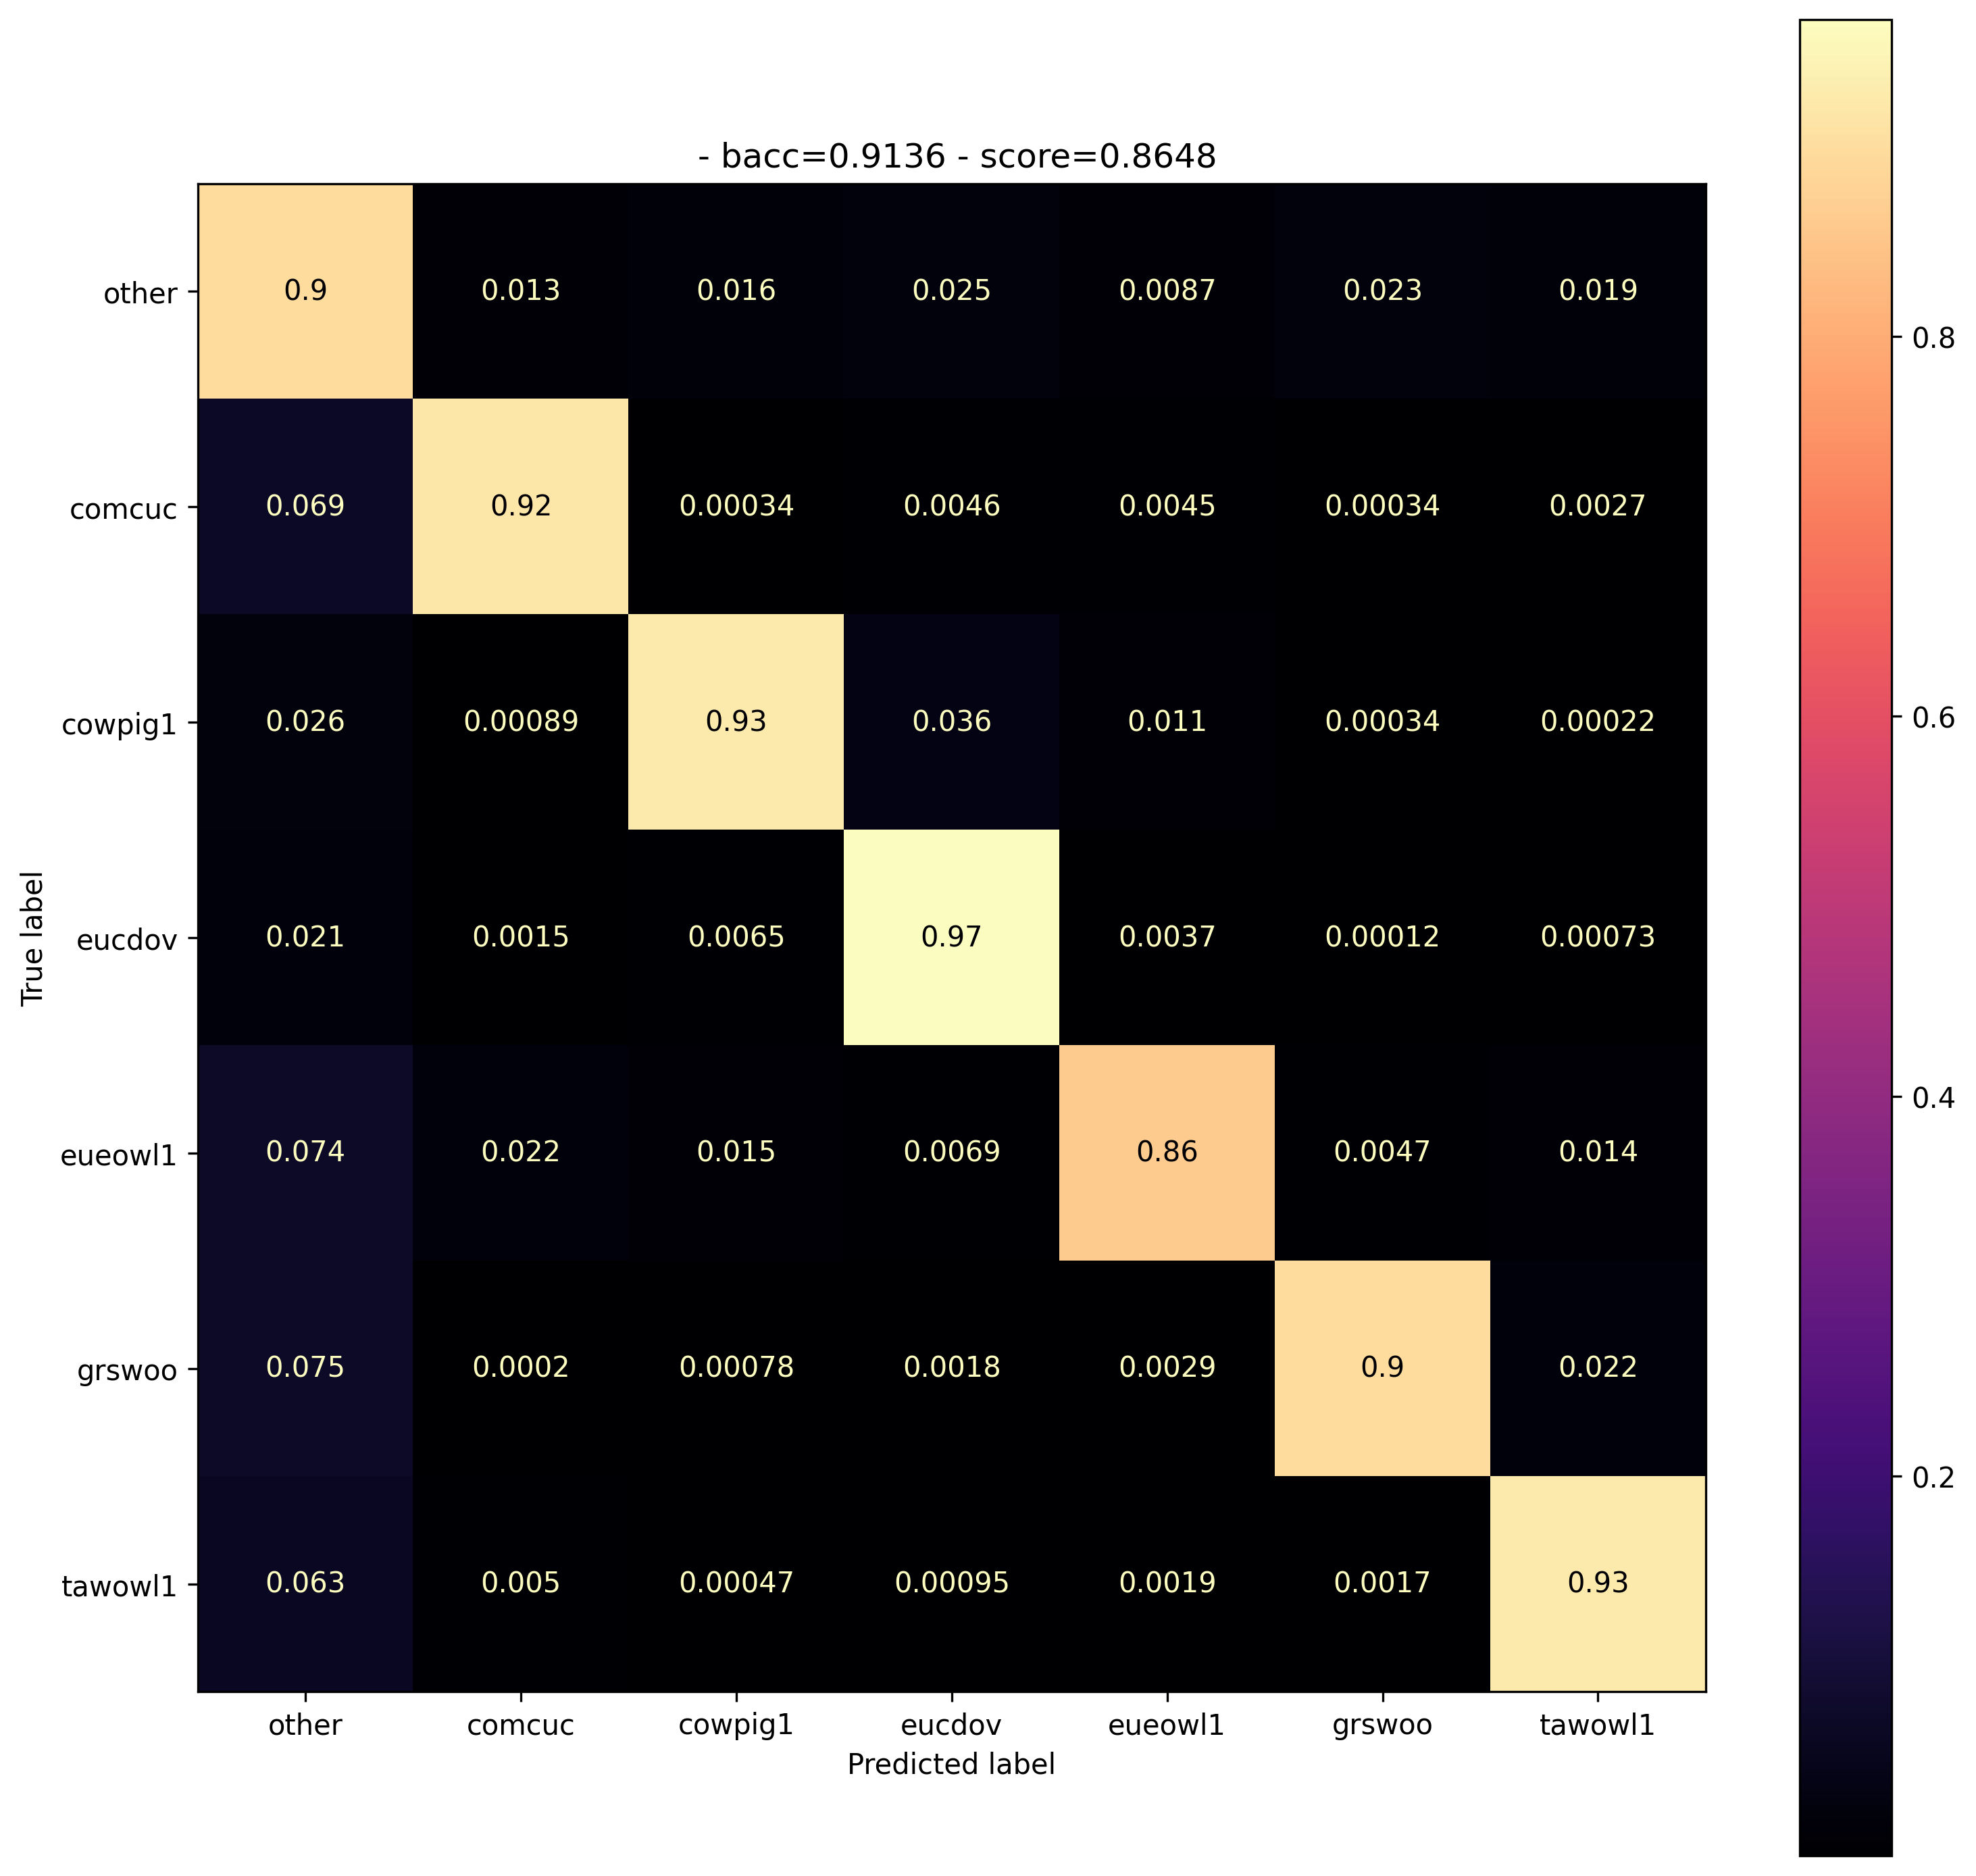

Saved model with scaler as "species_classifier full2023-06-21_22.35"


In [10]:
set_random_seed(41)

sequences_data_train_normalized, _, sequences_ds_train_normalization_scaler = normalize_data(sequences_ds_train.data, None)

sequences_ds_train_normalized = sequences_ds_train.copy()
sequences_ds_train_normalized.data = sequences_data_train_normalized


# data_raw_normalized, _, data_raw_normalization_scaler = normalize_data(data_raw, None)
# data_raw_normalized_ds = NumpyDataset(data_raw_normalized, labels)

full_train_ds = sequences_ds_train_normalized

# full_train_model = CNNClassifier(cnn_hyper_parameters)
full_train_model = SlidingAttentionClassifier(ac_hyper_parameters, batch_first=True)

fully_trained_latest_model, fully_trained_metrics, fully_trained_best_model, fully_trained_best_model_metrics = train_model(
    full_train_model,
    training_hyper_parameters,
    full_train_ds,
    full_train_ds,
    device
)

evaluate_model(
    fully_trained_latest_model, 
    create_data_loader(full_train_ds.data, full_train_ds.labels, 32, False), 
    device, 
    show_confmat=True, 
    confmat_title=''
)

save_model_with_scaler(fully_trained_latest_model, sequences_ds_train_normalization_scaler, f'species_classifier full{get_current_timestamp()}') # 2023-06-19_02.00
# save_model_with_scaler(fully_trained_latest_model, data_raw_normalization_scaler, 'species_classifier full') # 2023-06-19_02.00

# Plots

In [ ]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')